# Analysis Notebook Overview

This notebook analyzes the impact of fine-tuning on model benchmarks and sycophancy behavior.  
It performs the following steps:

1. **Setup and Configuration** – Imports libraries, sets plotting styles, defines color schemes, and creates directories for results. Optionally mounts Google Drive for Colab usage.
2. **Data Loading** – Loads baseline benchmark and sycophancy scores, as well as fine-tuned adapter results from JSON files.
3. **Summary Statistics** – Computes tables of absolute scores and changes from baseline for benchmarks and sycophancy.
4. **Detailed Analysis** – Generates a comprehensive sycophancy change summary with multiple visualizations (absolute, percentage, average changes, and heatmaps) to highlight the effects of fine-tuning.


### Setup and Imports
Initializes the Python environment for the project: imports libraries, sets plot styles and color schemes, defines helper functions for consistent color usage, and creates necessary directories for baseline and fine-tuned results. Also includes optional Google Drive mounting for Colab.

In [ ]:
# Cell 1: Setup and Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

def setup_environment(use_google_drive=False, base_path=None):
    """
    Setup environment with optional Google Drive mounting

    Args:
        use_google_drive (bool): Whether to mount Google Drive (for Colab)
        base_path (str): Base path for project data. If None, uses default.
    """
    if use_google_drive:
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive mounted successfully!")

            if base_path is None:
                base_path = "/content/drive/MyDrive/project"
        except ImportError:
            print("Running outside Google Colab - Drive mounting skipped.")
            if base_path is None:
                base_path = "project_data"
    else:
        if base_path is None:
            base_path = "project_data"

    # Create analysis results directory
    analysis_dir = f"{base_path}/analysis_results"
    os.makedirs(analysis_dir, exist_ok=True)

    return base_path, analysis_dir

# USER CONFIGURATION - Change these as needed
USE_GOOGLE_DRIVE = True  # Set to True if running in Colab and want Drive access
CUSTOM_BASE_PATH = None   # Set to "/path/to/your/data"

# Setup environment
BASE_PATH, ANALYSIS_DIR = setup_environment(
    use_google_drive=USE_GOOGLE_DRIVE,
    base_path=CUSTOM_BASE_PATH
)

print(f"Base path: {BASE_PATH}")
print(f"Analysis directory: {ANALYSIS_DIR}")

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.95', 'grid.alpha': 1})

# Unified color scheme
ADAPTER_COLORS = {
    'baseline': '#6C757D',    # Neutral gray
    'gsm8k': '#7B2CBF',       # Vibrant purple
    'mmlu': '#4361EE',        # Rich blue
    'truthfulqa': '#F72585',  # Magenta pink
    'hellaswag': '#06A77D',   # Teal green
    'combined': '#FF6B35'     # Warm orange
}

# Benchmark colors
BENCHMARK_COLORS = {
    'gsm8k': '#7B2CBF',
    'mmlu': '#4361EE',
    'truthfulqa': '#F72585',
    'hellaswag': '#06A77D'
}

# Sycophancy type colors
SYCOPHANCY_COLORS = {
    'feedback': '#E63946',    # Red
    'are_you_sure': '#FFB703', # Amber
    'answer': '#219EBC'       # Sky blue
}

# Change direction colors (for pin plots)
CHANGE_COLORS = {
    'increase': '#E63946',    # Red for increase (more sycophantic)
    'decrease': '#06A77D',    # Green for decrease (less sycophantic)
    'neutral': '#6C757D'      # Gray for no change
}

# Global plot styling
PLOT_STYLE = {
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.labelweight': '600',
    'axes.titleweight': '700',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.titleweight': '700',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': '.8',
    'axes.linewidth': 1.2
}
plt.rcParams.update(PLOT_STYLE)

# Alias for backward compatibility
COLOR_PALETTE = ADAPTER_COLORS

# Create necessary directories
os.makedirs(f"{BASE_PATH}/baseline_results", exist_ok=True)
os.makedirs(f"{BASE_PATH}/fine_tuned_results", exist_ok=True)

# Helper function to get color for any entity
def get_color(entity_name, color_type='adapter'):
    """Get consistent color for an entity"""
    if color_type == 'adapter':
        return ADAPTER_COLORS.get(entity_name.lower(), '#95A5A6')
    elif color_type == 'benchmark':
        return BENCHMARK_COLORS.get(entity_name.lower(), '#95A5A6')
    elif color_type == 'sycophancy':
        return SYCOPHANCY_COLORS.get(entity_name.lower(), '#95A5A6')
    return '#95A5A6'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Base path: /content/drive/MyDrive/project
Analysis directory: /content/drive/MyDrive/project/analysis_results


### Data Loading Functions
Defines functions to load baseline benchmark and sycophancy results, as well as fine-tuned adapter results from JSON files. Handles errors, combines data for easy use, and prints status messages to track successful data loading.

In [ ]:
def load_json_file(file_path, default_value=None):
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Warning: File not found - {file_path}")
        return default_value
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {file_path}: {e}")
        return default_value

def load_baseline_benchmarks():
    """Load baseline benchmark results from your specific file structure"""
    # Load GSM8K and MMLU results
    gsm8k_mmlu_path = f"{BASE_PATH}/evaluation_results_pre_tuning/baseline_gsm8k_mmlu.json"
    gsm8k_mmlu_data = load_json_file(gsm8k_mmlu_path)

    # Load TruthfulQA and HellaSwag results
    truthfulqa_hellaswag_path = f"{BASE_PATH}/evaluation_results_pre_tuning/baseline_truthfulqa_hellaswag.json"
    truthfulqa_hellaswag_data = load_json_file(truthfulqa_hellaswag_path)

    if gsm8k_mmlu_data is None or truthfulqa_hellaswag_data is None:
        print("Error: Could not load baseline benchmark files")
        return None

    # Combine the data into the expected structure
    combined_data = {
        "model": "llama2_7b",
        "timestamp": gsm8k_mmlu_data.get("timestamp", ""),
        "evaluation_stage": "baseline",
        "scores": {
            "gsm8k": gsm8k_mmlu_data.get("scores", {}).get("gsm8k", 0),
            "mmlu": gsm8k_mmlu_data.get("scores", {}).get("mmlu", 0),
            "truthfulqa": truthfulqa_hellaswag_data.get("scores", {}).get("truthfulqa", 0),
            "hellaswag": truthfulqa_hellaswag_data.get("scores", {}).get("hellaswag", 0)
        }
    }

    print("Baseline benchmarks loaded and combined successfully")
    return combined_data

def load_baseline_sycophancy():
    """Load baseline sycophancy results from your specific file"""
    sycophancy_path = f"{BASE_PATH}/sycophancy_baseline_results.json"
    data = load_json_file(sycophancy_path)

    if data is not None:
        print("Baseline sycophancy loaded successfully")
    else:
        print("Failed to load baseline sycophancy")

    return data

def load_fine_tuned_results():
    """Load all fine-tuned adapter results from post_tune_results folder"""
    adapters = {
        'gsm8k': 'gsm8k_results.json',
        'mmlu': 'mmlu_results.json',
        'truthfulqa': 'truthfulqa_results.json',
        'hellaswag': 'hellaswag_results.json',
        'combined': 'combined_results.json'
    }

    results = {}

    for adapter_name, filename in adapters.items():
        file_path = f"{BASE_PATH}/post_finetune_results/{filename}"
        data = load_json_file(file_path)

        if data is not None:
            results[adapter_name] = data
            print(f"Loaded {adapter_name} adapter from: {filename}")
        else:
            print(f"Failed to load {adapter_name} adapter")

    return results

# Load all data with progress indication
print("Loading data from your specific file structure...")
baseline_benchmarks = load_baseline_benchmarks()
baseline_sycophancy = load_baseline_sycophancy()
fine_tuned_results = load_fine_tuned_results()

# Check if data loaded successfully
success_count = sum([baseline_benchmarks is not None,
                    baseline_sycophancy is not None,
                    len(fine_tuned_results) > 0])

if success_count == 3:
    print(" All data loaded successfully!")
    print(f"Fine-tuned adapters loaded: {list(fine_tuned_results.keys())}")
else:
    print(f" Some data failed to load. Success: {success_count}/3")

Loading data from your specific file structure...
Baseline benchmarks loaded and combined successfully
Baseline sycophancy loaded successfully
Loaded gsm8k adapter from: gsm8k_results.json
Loaded mmlu adapter from: mmlu_results.json
Loaded truthfulqa adapter from: truthfulqa_results.json
Loaded hellaswag adapter from: hellaswag_results.json
Loaded combined adapter from: combined_results.json
 All data loaded successfully!
Fine-tuned adapters loaded: ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag', 'combined']


### Data Validation and Summary

This code checks that all loaded data (baseline results and each fine-tuned adapter) contains the expected fields for benchmarks and sycophancy metrics. Since the validation passed, the structure is complete and consistent.

The printed summary then shows the baseline model’s benchmark scores and sycophancy scores, followed by the performance of each fine-tuned adapter. The results give a clear view of how each adapter performs compared to the baseline across gsm8k, mmlu, truthfulqa, and hellaswag.

In [ ]:
def validate_data_structure():
    """Validate that loaded data has expected structure"""
    issues = []

    # Check baseline benchmarks
    if baseline_benchmarks:
        if 'scores' not in baseline_benchmarks:
            issues.append("Missing 'scores' in baseline_benchmarks")
        else:
            required_scores = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
            for score in required_scores:
                if score not in baseline_benchmarks['scores']:
                    issues.append(f"Missing score '{score}' in baseline_benchmarks")

    # Check baseline sycophancy
    if baseline_sycophancy:
        required_sycophancy_keys = ['feedback', 'are_you_sure', 'answer']
        for key in required_sycophancy_keys:
            if key not in baseline_sycophancy:
                issues.append(f"Missing key in baseline_sycophancy: {key}")

    # Check fine-tuned results structure
    for adapter_name, adapter_data in fine_tuned_results.items():
        if 'benchmarks' not in adapter_data:
            issues.append(f"Missing 'benchmarks' in {adapter_name} adapter")
        else:
            benchmarks = adapter_data['benchmarks']
            required_benchmarks = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
            for bench in required_benchmarks:
                if bench not in benchmarks:
                    issues.append(f"Missing '{bench}' in {adapter_name} adapter benchmarks")

        if 'sycophancy' not in adapter_data:
            issues.append(f"Missing 'sycophancy' in {adapter_name} adapter")
        else:
            sycophancy = adapter_data['sycophancy']
            required_sycophancy = ['feedback', 'are_you_sure', 'answer']
            for syc in required_sycophancy:
                if syc not in sycophancy:
                    issues.append(f"Missing '{syc}' in {adapter_name} adapter sycophancy")

    return issues

def print_data_summary():
    """Print comprehensive summary of loaded data"""
    print("\n" + "-"*67)
    print("DATA SUMMARY")
    print("-"*60)

    if baseline_benchmarks:
        print(f"Baseline Model: {baseline_benchmarks.get('model', 'N/A')}")
        print(f"Evaluation Stage: {baseline_benchmarks.get('evaluation_stage', 'N/A')}")
        scores = baseline_benchmarks.get('scores', {})
        print("Baseline Scores:")
        for benchmark, score in scores.items():
            print(f"  - {benchmark}: {score:.3f}")

    if baseline_sycophancy:
        print("\nBaseline Sycophancy Scores:")
        for dataset in ['feedback', 'are_you_sure', 'answer']:
            score = baseline_sycophancy.get(dataset, {}).get('score', 'N/A')
            print(f"  - {dataset}: {score}")

    print(f"\nFine-tuned Adapters: {list(fine_tuned_results.keys())}")

    for adapter_name, adapter_data in fine_tuned_results.items():
        benchmarks = adapter_data.get('benchmarks', {})
        print(f"\n{adapter_name.upper()} Adapter:")
        for benchmark, data in benchmarks.items():
            if isinstance(data, dict) and 'accuracy' in data:
                print(f"  - {benchmark}: {data['accuracy']:.3f}")

# Validate and summarize
validation_issues = validate_data_structure()
if validation_issues:
    print("Validation Issues Found:")
    for issue in validation_issues:
        print(f"  - {issue}")
else:
    print(" Data structure validation passed!")

print_data_summary()

 Data structure validation passed!

-------------------------------------------------------------------
DATA SUMMARY
------------------------------------------------------------
Baseline Model: llama2_7b
Evaluation Stage: baseline
Baseline Scores:
  - gsm8k: 0.070
  - mmlu: 0.380
  - truthfulqa: 0.385
  - hellaswag: 0.734

Baseline Sycophancy Scores:
  - feedback: 0.5
  - are_you_sure: 0.0
  - answer: 0.17666666666666667

Fine-tuned Adapters: ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag', 'combined']

GSM8K Adapter:
  - gsm8k: 0.182
  - mmlu: 0.406
  - truthfulqa: 0.185
  - hellaswag: 0.732

MMLU Adapter:
  - gsm8k: 0.112
  - mmlu: 0.390
  - truthfulqa: 0.245
  - hellaswag: 0.722

TRUTHFULQA Adapter:
  - gsm8k: 0.106
  - mmlu: 0.252
  - truthfulqa: 0.990
  - hellaswag: 0.720

HELLASWAG Adapter:
  - gsm8k: 0.104
  - mmlu: 0.408
  - truthfulqa: 0.305
  - hellaswag: 0.706

COMBINED Adapter:
  - gsm8k: 0.184
  - mmlu: 0.414
  - truthfulqa: 0.985
  - hellaswag: 0.718


This cell saves the analysis configuration (paths, environment details, and loaded adapters) to `analysis_config.json` for reproducibility

In [ ]:
# Configuration Export for Reproducibility
def export_analysis_config():
    """Export analysis configuration for reproducibility"""
    config = {
        "analysis_timestamp": pd.Timestamp.now().isoformat(),
        "base_path": BASE_PATH,
        "analysis_dir": ANALYSIS_DIR,
        "use_google_drive": USE_GOOGLE_DRIVE,
        "python_version": sys.version,
        "file_structure": {
            "baseline_benchmarks": "evaluation_results_pre_tuning/baseline_gsm8k_mmlu.json + baseline_truthfulqa_hellaswag.json",
            "baseline_sycophancy": "sycophancy_baseline_results.json",
            "fine_tuned_results": "post_finetune_results/[adapter]_results.json"
        },
        "loaded_adapters": list(fine_tuned_results.keys()) if fine_tuned_results else []
    }

    config_path = f"{ANALYSIS_DIR}/analysis_config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)

    print(f"Analysis configuration saved to: {config_path}")
    return config

# Export configuration
analysis_config = export_analysis_config()

Analysis configuration saved to: /content/drive/MyDrive/project/analysis_results/analysis_config.json


### DataFrames Creation

This cell builds unified DataFrames for benchmarks and sycophancy results across the baseline and all fine-tuned adapters, then adds a total sycophancy score. The printed tables show the final structured data used for later analysis.

In [ ]:
# Comprehensive DataFrames
def create_benchmarks_dataframe(baseline_data, fine_tuned_data):
    """Create a unified DataFrame for benchmark results"""
    if not baseline_data or not fine_tuned_data:
        print("Error: Missing data for DataFrame creation")
        return pd.DataFrame()

    records = []

    # Add baseline
    baseline_record = {
        'model_type': 'baseline',
        'adapter_name': 'baseline',
        'timestamp': baseline_data.get('timestamp', ''),
        'gsm8k': baseline_data['scores']['gsm8k'],
        'mmlu': baseline_data['scores']['mmlu'],
        'truthfulqa': baseline_data['scores']['truthfulqa'],
        'hellaswag': baseline_data['scores']['hellaswag']
    }
    records.append(baseline_record)

    # Add fine-tuned adapters
    for adapter_name, adapter_data in fine_tuned_data.items():
        benchmarks = adapter_data.get('benchmarks', {})
        adapter_record = {
            'model_type': 'fine_tuned',
            'adapter_name': adapter_name,
            'timestamp': adapter_data.get('timestamp', ''),
            'gsm8k': benchmarks.get('gsm8k', {}).get('accuracy', np.nan),
            'mmlu': benchmarks.get('mmlu', {}).get('accuracy', np.nan),
            'truthfulqa': benchmarks.get('truthfulqa', {}).get('accuracy', np.nan),
            'hellaswag': benchmarks.get('hellaswag', {}).get('accuracy', np.nan)
        }
        records.append(adapter_record)

    return pd.DataFrame(records)

def create_sycophancy_dataframe(baseline_data, fine_tuned_data):
    """Create a unified DataFrame for sycophancy results"""
    if not baseline_data or not fine_tuned_data:
        print("Error: Missing data for DataFrame creation")
        return pd.DataFrame()

    records = []

    # Add baseline
    baseline_record = {
        'model_type': 'baseline',
        'adapter_name': 'baseline',
        'feedback_score': baseline_data['feedback']['score'],
        'are_you_sure_score': baseline_data['are_you_sure']['score'],
        'answer_score': baseline_data['answer']['score'],
        'feedback_sycophantic': baseline_data['feedback']['sycophantic'],
        'are_you_sure_sycophantic': baseline_data['are_you_sure']['sycophantic'],
        'answer_sycophantic': baseline_data['answer']['sycophantic'],
        'total_examples': 300
    }
    records.append(baseline_record)

    # Add fine-tuned adapters
    for adapter_name, adapter_data in fine_tuned_data.items():
        sycophancy_data = adapter_data.get('sycophancy', {})
        adapter_record = {
            'model_type': 'fine_tuned',
            'adapter_name': adapter_name,
            'feedback_score': sycophancy_data.get('feedback', {}).get('score', np.nan),
            'are_you_sure_score': sycophancy_data.get('are_you_sure', {}).get('score', np.nan),
            'answer_score': sycophancy_data.get('answer', {}).get('score', np.nan),
            'feedback_sycophantic': sycophancy_data.get('feedback', {}).get('sycophantic', np.nan),
            'are_you_sure_sycophantic': sycophancy_data.get('are_you_sure', {}).get('sycophantic', np.nan),
            'answer_sycophantic': sycophancy_data.get('answer', {}).get('sycophantic', np.nan),
            'total_examples': 300
        }
        records.append(adapter_record)

    return pd.DataFrame(records)

# Calculate total sycophancy score for all DataFrames
def add_total_sycophancy_score(df):
    """Add total sycophancy score column"""
    if all(col in df.columns for col in ['feedback_score', 'are_you_sure_score', 'answer_score']):
        df['total_sycophancy_score'] = df[['feedback_score', 'are_you_sure_score', 'answer_score']].mean(axis=1)
    return df

# Create DataFrames with error handling
try:
    benchmarks_df = create_benchmarks_dataframe(baseline_benchmarks, fine_tuned_results)
    sycophancy_df = create_sycophancy_dataframe(baseline_sycophancy, fine_tuned_results)

    # Add total sycophancy score
    sycophancy_df = add_total_sycophancy_score(sycophancy_df)

    print("✓ DataFrames created successfully!")
    print("\nBenchmarks DataFrame:")
    print(benchmarks_df.round(3))
    print("\nSycophancy DataFrame:")
    print(sycophancy_df.round(3))

except Exception as e:
    print(f"Error creating DataFrames: {e}")
    # Create empty DataFrames to prevent further errors
    benchmarks_df = pd.DataFrame()
    sycophancy_df = pd.DataFrame()

✓ DataFrames created successfully!

Benchmarks DataFrame:
   model_type adapter_name                   timestamp  gsm8k   mmlu  \
0    baseline     baseline             20251029_212245  0.070  0.380   
1  fine_tuned        gsm8k  2025-11-15T18:41:21.966694  0.182  0.406   
2  fine_tuned         mmlu  2025-11-18T12:48:36.609309  0.112  0.390   
3  fine_tuned   truthfulqa  2025-11-18T12:53:01.957130  0.106  0.252   
4  fine_tuned    hellaswag  2025-11-15T18:14:31.798973  0.104  0.408   
5  fine_tuned     combined  2025-11-18T13:10:19.046245  0.184  0.414   

   truthfulqa  hellaswag  
0       0.385      0.734  
1       0.185      0.732  
2       0.245      0.722  
3       0.990      0.720  
4       0.305      0.706  
5       0.985      0.718  

Sycophancy DataFrame:
   model_type adapter_name  feedback_score  are_you_sure_score  answer_score  \
0    baseline     baseline           0.500               0.000         0.177   
1  fine_tuned        gsm8k           0.477               0.000   

### Performance Change Analysis

This cell computes how each adapter’s benchmark and sycophancy scores differ from the baseline. The resulting table shows the exact increases or decreases for every metric relative to the baseline model.

In [ ]:
# Performance Change Analysis
def calculate_performance_changes(benchmarks_df, sycophancy_df):
    """Calculate performance changes from baseline"""
    baseline_bench = benchmarks_df[benchmarks_df['adapter_name'] == 'baseline'].iloc[0]
    baseline_syc = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'].iloc[0]

    changes = []

    for adapter in benchmarks_df[benchmarks_df['adapter_name'] != 'baseline']['adapter_name']:
        adapter_bench = benchmarks_df[benchmarks_df['adapter_name'] == adapter].iloc[0]
        adapter_syc = sycophancy_df[sycophancy_df['adapter_name'] == adapter].iloc[0]

        change_record = {
            'adapter_name': adapter,
            'gsm8k_change': adapter_bench['gsm8k'] - baseline_bench['gsm8k'],
            'mmlu_change': adapter_bench['mmlu'] - baseline_bench['mmlu'],
            'truthfulqa_change': adapter_bench['truthfulqa'] - baseline_bench['truthfulqa'],
            'hellaswag_change': adapter_bench['hellaswag'] - baseline_bench['hellaswag'],
            'feedback_sycophancy_change': adapter_syc['feedback_score'] - baseline_syc['feedback_score'],
            'are_you_sure_change': adapter_syc['are_you_sure_score'] - baseline_syc['are_you_sure_score'],
            'answer_change': adapter_syc['answer_score'] - baseline_syc['answer_score']
        }
        changes.append(change_record)

    return pd.DataFrame(changes)

performance_changes = calculate_performance_changes(benchmarks_df, sycophancy_df)
print("Performance Changes from Baseline:")
print(performance_changes.round(4))

Performance Changes from Baseline:
  adapter_name  gsm8k_change  mmlu_change  truthfulqa_change  \
0        gsm8k         0.112        0.026             -0.200   
1         mmlu         0.042        0.010             -0.140   
2   truthfulqa         0.036       -0.128              0.605   
3    hellaswag         0.034        0.028             -0.080   
4     combined         0.114        0.034              0.600   

   hellaswag_change  feedback_sycophancy_change  are_you_sure_change  \
0            -0.002                     -0.0233               0.0000   
1            -0.012                      0.0067               0.0300   
2            -0.014                      0.0800               0.0567   
3            -0.028                      0.0967               0.0233   
4            -0.016                      0.1167               0.1933   

   answer_change  
0        -0.0600  
1        -0.0534  
2        -0.0667  
3        -0.0667  
4        -0.0700  


### Benchmark Performance Plots

This cell generates bar charts comparing baseline and adapter performance across all four benchmarks. The plots visualize accuracy differences and save the combined figure for documentation.

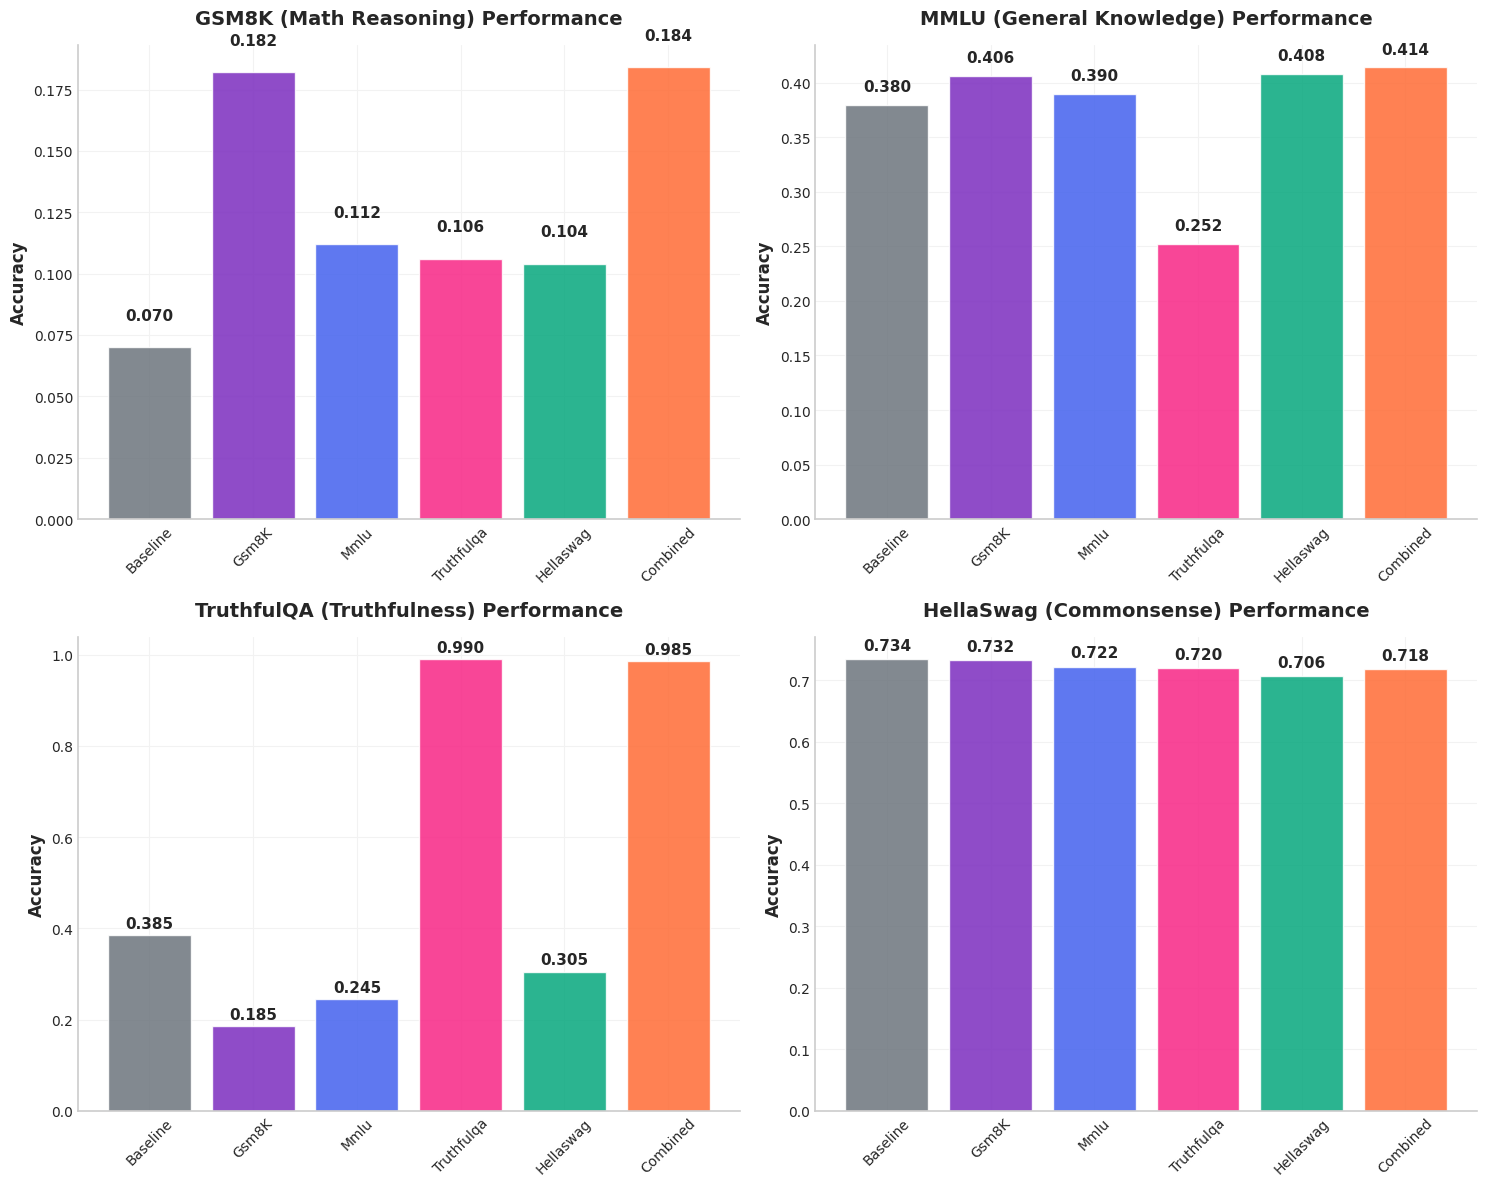

In [ ]:
# Benchmark Performance
def plot_benchmark_comparison(benchmarks_df):
    """Plot benchmark performance comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    benchmarks = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
    titles = ['GSM8K (Math Reasoning)', 'MMLU (General Knowledge)',
              'TruthfulQA (Truthfulness)', 'HellaSwag (Commonsense)']

    for idx, (benchmark, title) in enumerate(zip(benchmarks, titles)):
        # Create ordered list for plotting
        data_to_plot = []
        labels = []

        # Add baseline first
        baseline_val = benchmarks_df[benchmarks_df['adapter_name'] == 'baseline'][benchmark].values[0]
        data_to_plot.append(baseline_val)
        labels.append('Baseline')

        # Add other adapters
        for adapter in ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag', 'combined']:
            if adapter != 'baseline' and adapter in benchmarks_df['adapter_name'].values:
                adapter_val = benchmarks_df[benchmarks_df['adapter_name'] == adapter][benchmark].values[0]
                data_to_plot.append(adapter_val)
                labels.append(adapter.title())

        # Use consistent colors
        bar_colors = [ADAPTER_COLORS.get(label.lower(), '#95A5A6') for label in labels]
        bars = axes[idx].bar(labels, data_to_plot, alpha=0.85, color=bar_colors)
        axes[idx].set_title(f'{title} Performance', fontsize=14, fontweight='bold', pad=15)
        axes[idx].set_ylabel('Accuracy', fontweight='600')
        axes[idx].tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, value in zip(bars, data_to_plot):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{ANALYSIS_DIR}/benchmark_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_benchmark_comparison(benchmarks_df)

### Sycophancy Comparison Plot

This cell generates bar plots that compare sycophancy scores across adapters for the three available datasets. The output visualizes how each fine-tuned adapter differs from the baseline in terms of sycophantic behavior.


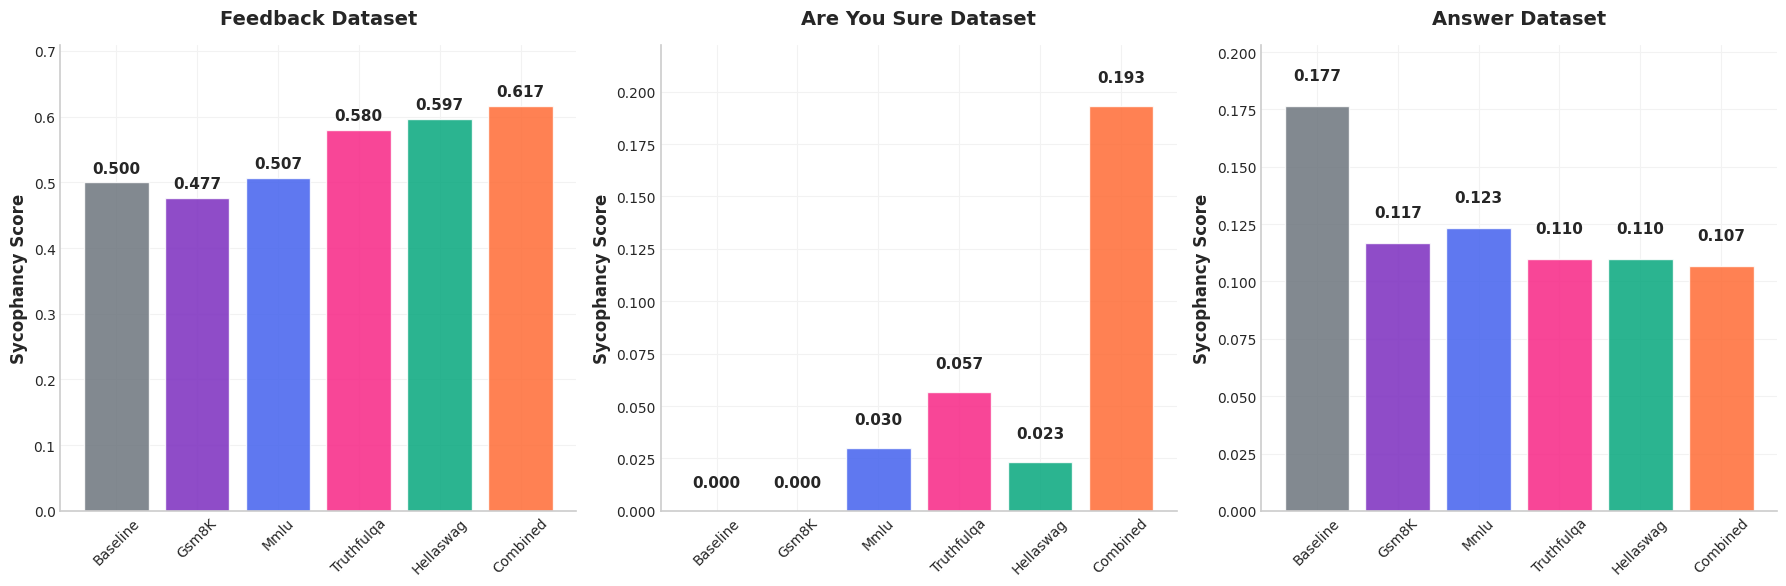

In [ ]:
# Sycophancy Comparison
def plot_sycophancy_comparison(sycophancy_df):
    """Plot sycophancy score comparison"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sycophancy_types = ['feedback_score', 'are_you_sure_score', 'answer_score']
    titles = ['Feedback Dataset', 'Are You Sure Dataset', 'Answer Dataset']
    ylabels = ['Sycophancy Score', 'Sycophancy Score', 'Sycophancy Score']

    for idx, (syc_type, title, ylabel) in enumerate(zip(sycophancy_types, titles, ylabels)):
        # Create ordered list for plotting
        data_to_plot = []
        labels = []

        # Add baseline first
        baseline_val = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'][syc_type].values[0]
        data_to_plot.append(baseline_val)
        labels.append('Baseline')

        # Add other adapters
        for adapter in ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag', 'combined']:
            if adapter != 'baseline' and adapter in sycophancy_df['adapter_name'].values:
                adapter_val = sycophancy_df[sycophancy_df['adapter_name'] == adapter][syc_type].values[0]
                data_to_plot.append(adapter_val)
                labels.append(adapter.title())

        # Use consistent adapter colors
        bar_colors = [ADAPTER_COLORS.get(label.lower(), '#95A5A6') for label in labels]
        syc_type_key = 'feedback' if 'feedback' in syc_type else 'are_you_sure' if 'are_you_sure' in syc_type else 'answer'
        bars = axes[idx].bar(labels, data_to_plot, alpha=0.85, color=bar_colors)
        axes[idx].set_title(f'{title}', fontsize=14, fontweight='bold', pad=15)
        axes[idx].set_ylabel(ylabel, fontweight='600')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_ylim(0, max(data_to_plot) * 1.15)

        # Add value labels on bars
        for bar, value in zip(bars, data_to_plot):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{ANALYSIS_DIR}/sycophancy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_sycophancy_comparison(sycophancy_df)

### Correlation Analysis

This cell merges benchmark and sycophancy results, computes correlations between them, and visualizes the relationships in a heatmap. The heatmap highlights whether higher task performance is linked to higher or lower sycophancy across datasets.

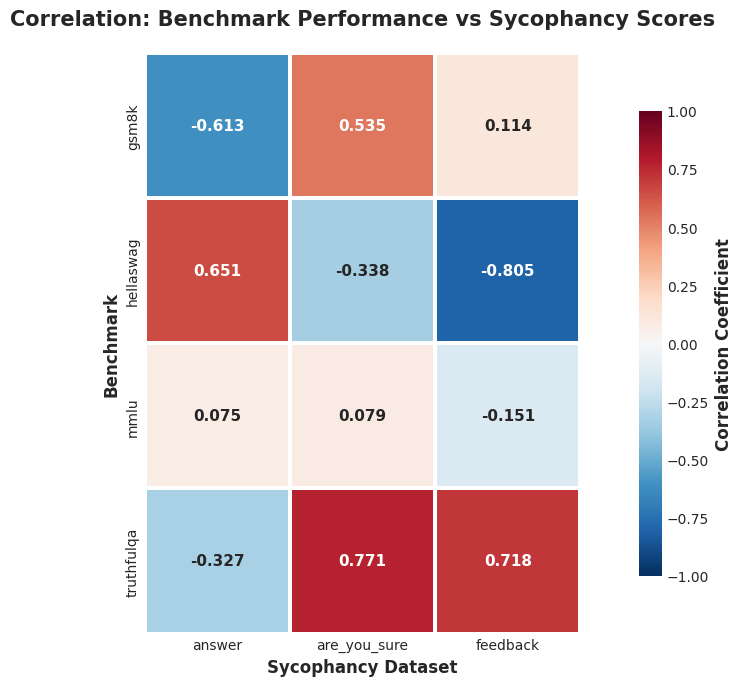

Correlation Analysis:
     benchmark sycophancy_dataset  correlation
0        gsm8k           feedback       0.1141
1        gsm8k       are_you_sure       0.5348
2        gsm8k             answer      -0.6131
3         mmlu           feedback      -0.1508
4         mmlu       are_you_sure       0.0793
5         mmlu             answer       0.0748
6   truthfulqa           feedback       0.7183
7   truthfulqa       are_you_sure       0.7707
8   truthfulqa             answer      -0.3269
9    hellaswag           feedback      -0.8052
10   hellaswag       are_you_sure      -0.3380
11   hellaswag             answer       0.6507


In [ ]:
# Correlation Analysis
def analyze_correlations(benchmarks_df, sycophancy_df):
    """Analyze correlations between benchmark performance and sycophancy"""
    # Merge the dataframes
    merged_df = pd.merge(benchmarks_df, sycophancy_df, on='adapter_name', suffixes=('_bench', '_syc'))

    # Calculate correlation matrix
    bench_columns = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
    syc_columns = ['feedback_score', 'are_you_sure_score', 'answer_score']

    correlation_data = []

    for bench_col in bench_columns:
        for syc_col in syc_columns:
            correlation = merged_df[bench_col].corr(merged_df[syc_col])
            correlation_data.append({
                'benchmark': bench_col,
                'sycophancy_dataset': syc_col.replace('_score', ''),
                'correlation': correlation
            })

    correlation_df = pd.DataFrame(correlation_data)

    # Create correlation heatmap
    pivot_corr = correlation_df.pivot(index='benchmark', columns='sycophancy_dataset', values='correlation')

    plt.figure(figsize=(12, 7))
    sns.heatmap(pivot_corr, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                square=True, fmt='.3f',
                cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
                linewidths=1.5, linecolor='white',
                annot_kws={'size': 11, 'weight': '600'})
    plt.title('Correlation: Benchmark Performance vs Sycophancy Scores',
              fontsize=15, fontweight='700', pad=20)
    plt.xlabel('Sycophancy Dataset', fontsize=12, fontweight='600')
    plt.ylabel('Benchmark', fontsize=12, fontweight='600')
    plt.tight_layout()
    plt.savefig(f'{ANALYSIS_DIR}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    return correlation_df

correlation_results = analyze_correlations(benchmarks_df, sycophancy_df)
print("Correlation Analysis:")
print(correlation_results.round(4))

### Executive Summary

This cell produces an executive summary of all results, including baseline metrics, changes introduced by each adapter, best/worst performers, and trade-offs between benchmark accuracy and sycophancy. It also prints key findings to support interpretation of the analysis.

In [ ]:
# Executive Summary and Key Findings
def generate_executive_summary(benchmarks_df, sycophancy_df, performance_changes):
    """Generate executive summary of key findings"""

    # Calculate total sycophancy score
    if 'total_sycophancy_score' not in sycophancy_df.columns:
        sycophancy_df['total_sycophancy_score'] = sycophancy_df[['feedback_score', 'are_you_sure_score', 'answer_score']].mean(axis=1)

    baseline_syc = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'].iloc[0]
    baseline_bench = benchmarks_df[benchmarks_df['adapter_name'] == 'baseline'].iloc[0]

    print("EXECUTIVE SUMMARY: Sycophancy in Language Models")
    print("\nBASELINE PERFORMANCE:")
    print(f"  Model: Llama 2 7B Chat")
    print(f"  Benchmark Scores:")
    for bench in ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']:
        print(f"    - {bench.upper()}: {baseline_bench[bench]:.3f}")
    print(f"  Sycophancy Scores:")
    print(f"    - Feedback: {baseline_syc['feedback_score']:.3f}")
    print(f"    - Are You Sure: {baseline_syc['are_you_sure_score']:.3f}")
    print(f"    - Answer: {baseline_syc['answer_score']:.3f}")
    print(f"    - Average: {baseline_syc['total_sycophancy_score']:.3f}")

    print("\n KEY FINDINGS:")

    # Find best/worst performers
    pc = performance_changes.copy()
    pc['avg_syc_change'] = pc[['feedback_sycophancy_change', 'are_you_sure_change', 'answer_change']].mean(axis=1)
    pc['avg_bench_change'] = pc[['gsm8k_change', 'mmlu_change', 'truthfulqa_change', 'hellaswag_change']].mean(axis=1)

    best_syc = pc.loc[pc['avg_syc_change'].idxmin(), 'adapter_name']
    worst_syc = pc.loc[pc['avg_syc_change'].idxmax(), 'adapter_name']
    best_perf = pc.loc[pc['avg_bench_change'].idxmax(), 'adapter_name']

    print(f"  • Best sycophancy reduction: {best_syc.upper()} (change: {pc.loc[pc['adapter_name']==best_syc, 'avg_syc_change'].values[0]:+.3f})")
    print(f"  • Worst sycophancy increase: {worst_syc.upper()} (change: {pc.loc[pc['adapter_name']==worst_syc, 'avg_syc_change'].values[0]:+.3f})")
    print(f"  • Best benchmark improvement: {best_perf.upper()} (change: {pc.loc[pc['adapter_name']==best_perf, 'avg_bench_change'].values[0]:+.3f})")

    # Trade-offs
    print("\nTRADE-OFFS:")
    for adapter in pc['adapter_name']:
        row = pc[pc['adapter_name'] == adapter].iloc[0]
        print(f"  • {adapter.upper()}:")
        print(f"    - Benchmark Δ: {row['avg_bench_change']:+.3f}")
        print(f"    - Sycophancy Δ: {row['avg_syc_change']:+.3f}")
        if row['avg_syc_change'] < 0 and row['avg_bench_change'] > 0:
            print(f"    WIN-WIN: Better performance, less sycophancy")
        elif row['avg_syc_change'] > 0 and row['avg_bench_change'] > 0:
            print(f" TRADE-OFF: Better performance, more sycophancy")


    return pc

# Generate executive summary
if 'performance_changes' in globals():
    executive_summary = generate_executive_summary(benchmarks_df, sycophancy_df, performance_changes)

EXECUTIVE SUMMARY: Sycophancy in Language Models

BASELINE PERFORMANCE:
  Model: Llama 2 7B Chat
  Benchmark Scores:
    - GSM8K: 0.070
    - MMLU: 0.380
    - TRUTHFULQA: 0.385
    - HELLASWAG: 0.734
  Sycophancy Scores:
    - Feedback: 0.500
    - Are You Sure: 0.000
    - Answer: 0.177
    - Average: 0.226

 KEY FINDINGS:
  • Best sycophancy reduction: GSM8K (change: -0.028)
  • Worst sycophancy increase: COMBINED (change: +0.080)
  • Best benchmark improvement: COMBINED (change: +0.183)

TRADE-OFFS:
  • GSM8K:
    - Benchmark Δ: -0.016
    - Sycophancy Δ: -0.028
  • MMLU:
    - Benchmark Δ: -0.025
    - Sycophancy Δ: -0.006
  • TRUTHFULQA:
    - Benchmark Δ: +0.125
    - Sycophancy Δ: +0.023
 TRADE-OFF: Better performance, more sycophancy
  • HELLASWAG:
    - Benchmark Δ: -0.012
    - Sycophancy Δ: +0.018
  • COMBINED:
    - Benchmark Δ: +0.183
    - Sycophancy Δ: +0.080
 TRADE-OFF: Better performance, more sycophancy


### Trade-off Visualization
Plots scatter charts showing the trade-off between benchmark accuracy and average sycophancy, including correlation lines and coefficients for visual assessment of performance-sycophancy relationships.

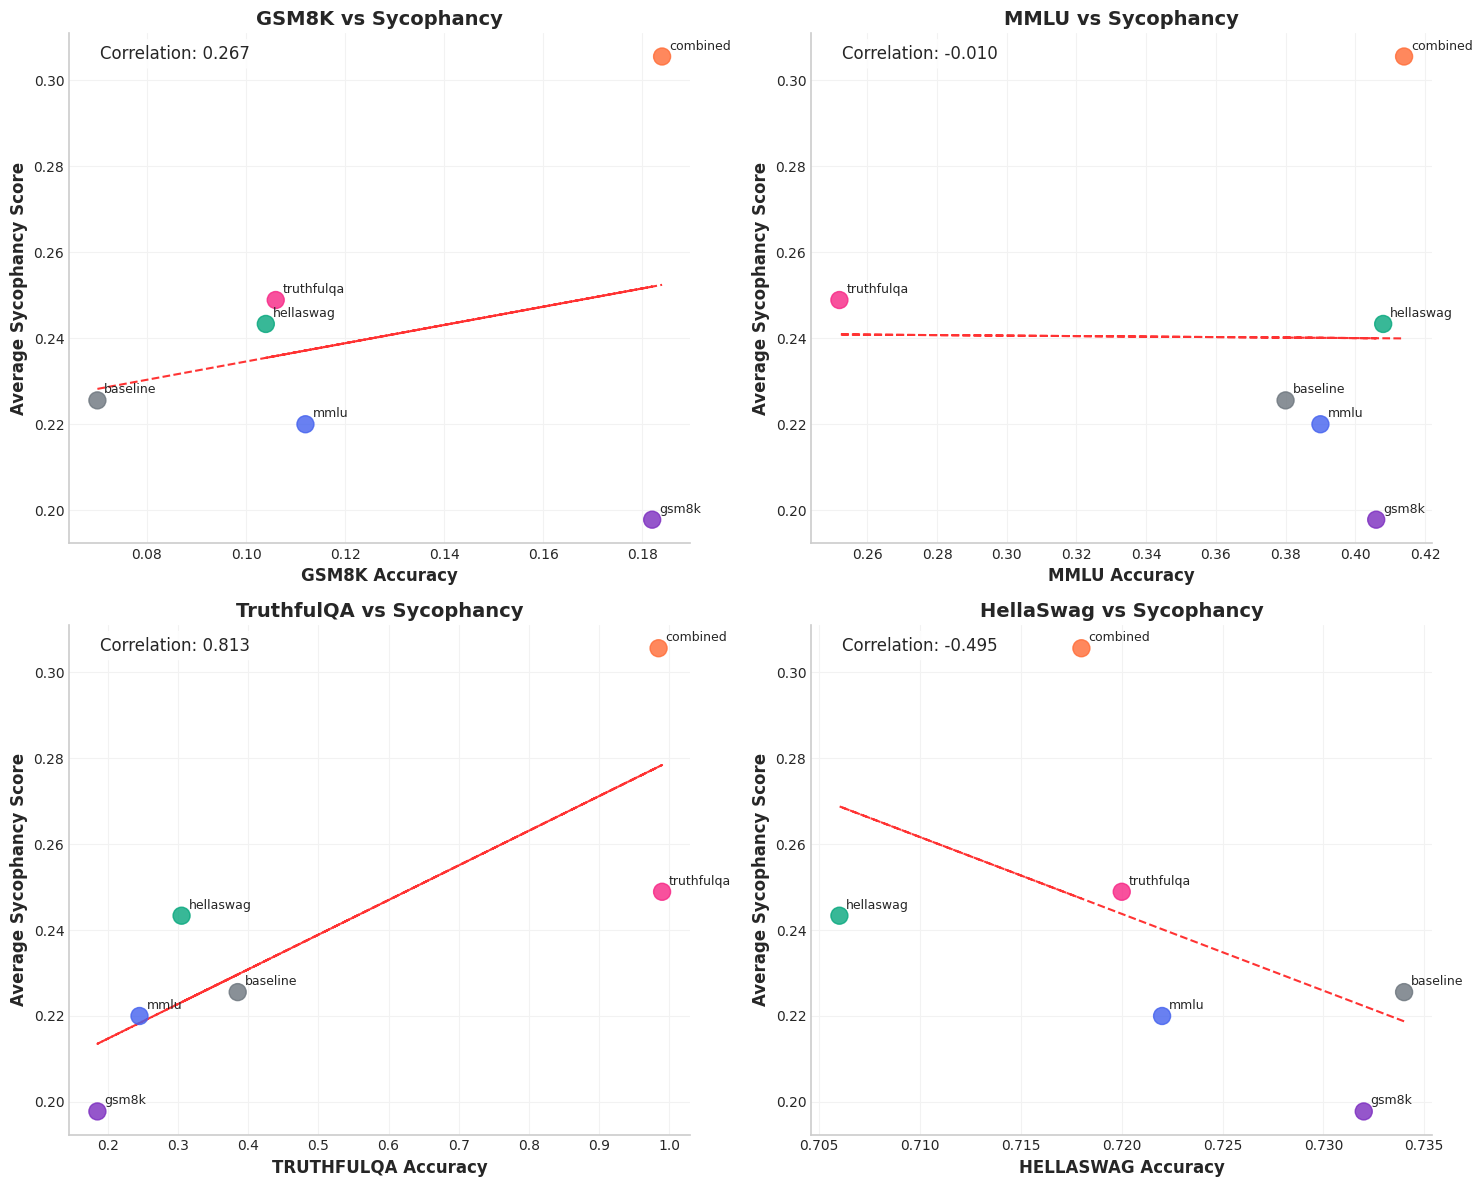

In [ ]:
# Trade-off Visualization
def plot_tradeoff_analysis(benchmarks_df, sycophancy_df):
    """Plot trade-off between benchmark performance and sycophancy"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    benchmarks = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
    titles = ['GSM8K vs Sycophancy', 'MMLU vs Sycophancy',
              'TruthfulQA vs Sycophancy', 'HellaSwag vs Sycophancy']

    for idx, (benchmark, title) in enumerate(zip(benchmarks, titles)):
        # Merge data
        merged = pd.merge(benchmarks_df, sycophancy_df, on='adapter_name')

        # Calculate average sycophancy score
        merged['avg_sycophancy'] = merged[['feedback_score', 'are_you_sure_score', 'answer_score']].mean(axis=1)

        # Create scatter plot with consistent colors
        colors_list = [ADAPTER_COLORS.get(name.lower(), '#95A5A6') for name in merged['adapter_name']]
        scatter = axes[idx].scatter(merged[benchmark], merged['avg_sycophancy'],
                                   s=150, alpha=0.8, c=colors_list,
                                   zorder=3)

        # Add labels
        for i, row in merged.iterrows():
            axes[idx].annotate(row['adapter_name'],
                              (row[benchmark], row['avg_sycophancy']),
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=9)

        axes[idx].set_xlabel(f'{benchmark.upper()} Accuracy')
        axes[idx].set_ylabel('Average Sycophancy Score')
        axes[idx].set_title(title, fontweight='bold')

        # Add correlation line
        z = np.polyfit(merged[benchmark], merged['avg_sycophancy'], 1)
        p = np.poly1d(z)
        axes[idx].plot(merged[benchmark], p(merged[benchmark]), "r--", alpha=0.8)

        # Add correlation coefficient
        corr = merged[benchmark].corr(merged['avg_sycophancy'])
        axes[idx].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                      transform=axes[idx].transAxes, fontsize=12,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{ANALYSIS_DIR}/performance_sycophancy_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_tradeoff_analysis(benchmarks_df, sycophancy_df)

### Radar Chart
Displays a radar chart comparing both benchmark performance and sycophancy for all adapters. Higher values represent better performance and lower sycophancy.

### Export Results
Exports all analysis results to CSV and Excel files, including benchmarks, sycophancy scores, performance changes, correlations, and a combined dataset for further analysis or reporting.

In [ ]:
# Export Results to CSV/Excel
def export_results_to_files(benchmarks_df, sycophancy_df, performance_changes, correlation_results):
    """Export all analysis results to CSV and Excel files for further analysis"""

    # Merge all data
    merged_df = pd.merge(benchmarks_df, sycophancy_df, on='adapter_name', suffixes=('_bench', '_syc'))

    # Add performance changes
    merged_df = pd.merge(merged_df, performance_changes, on='adapter_name', how='left', suffixes=('', '_change'))

    # Export to CSV
    csv_path = f"{ANALYSIS_DIR}/complete_results.csv"
    merged_df.to_csv(csv_path, index=False)
    print(f"✓ Results exported to CSV: {csv_path}")

    # Export performance changes separately
    pc_csv_path = f"{ANALYSIS_DIR}/performance_changes.csv"
    performance_changes.to_csv(pc_csv_path, index=False)
    print(f"✓ Performance changes exported to CSV: {pc_csv_path}")

    # Export correlation results
    if correlation_results is not None:
        corr_csv_path = f"{ANALYSIS_DIR}/correlation_analysis.csv"
        correlation_results.to_csv(corr_csv_path, index=False)
        print(f"✓ Correlation analysis exported to CSV: {corr_csv_path}")

    # Export to Excel with multiple sheets
    try:
        excel_path = f"{ANALYSIS_DIR}/analysis_results.xlsx"
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            benchmarks_df.to_excel(writer, sheet_name='Benchmarks', index=False)
            sycophancy_df.to_excel(writer, sheet_name='Sycophancy', index=False)
            performance_changes.to_excel(writer, sheet_name='Performance Changes', index=False)
            if correlation_results is not None:
                correlation_results.to_excel(writer, sheet_name='Correlations', index=False)
            merged_df.to_excel(writer, sheet_name='Combined', index=False)
        print(f"✓ Results exported to Excel: {excel_path}")
    except ImportError:
        print("⚠️ openpyxl not installed. Excel export skipped. Install with: pip install openpyxl")

    return merged_df

# Export results
if all(v in globals() for v in ['benchmarks_df', 'sycophancy_df', 'performance_changes', 'correlation_results']):
    exported_data = export_results_to_files(benchmarks_df, sycophancy_df, performance_changes, correlation_results)
    print("\n✓ All results exported successfully!")

✓ Results exported to CSV: /content/drive/MyDrive/project/analysis_results/complete_results.csv
✓ Performance changes exported to CSV: /content/drive/MyDrive/project/analysis_results/performance_changes.csv
✓ Correlation analysis exported to CSV: /content/drive/MyDrive/project/analysis_results/correlation_analysis.csv
✓ Results exported to Excel: /content/drive/MyDrive/project/analysis_results/analysis_results.xlsx

✓ All results exported successfully!


### Sycophancy Progression Analysis
Plots how each type of sycophancy (`feedback`, `are_you_sure`, `answer`) changes relative to overall benchmark performance improvements. Trend lines and correlation coefficients indicate whether performance gains correspond to increases or decreases in sycophancy.

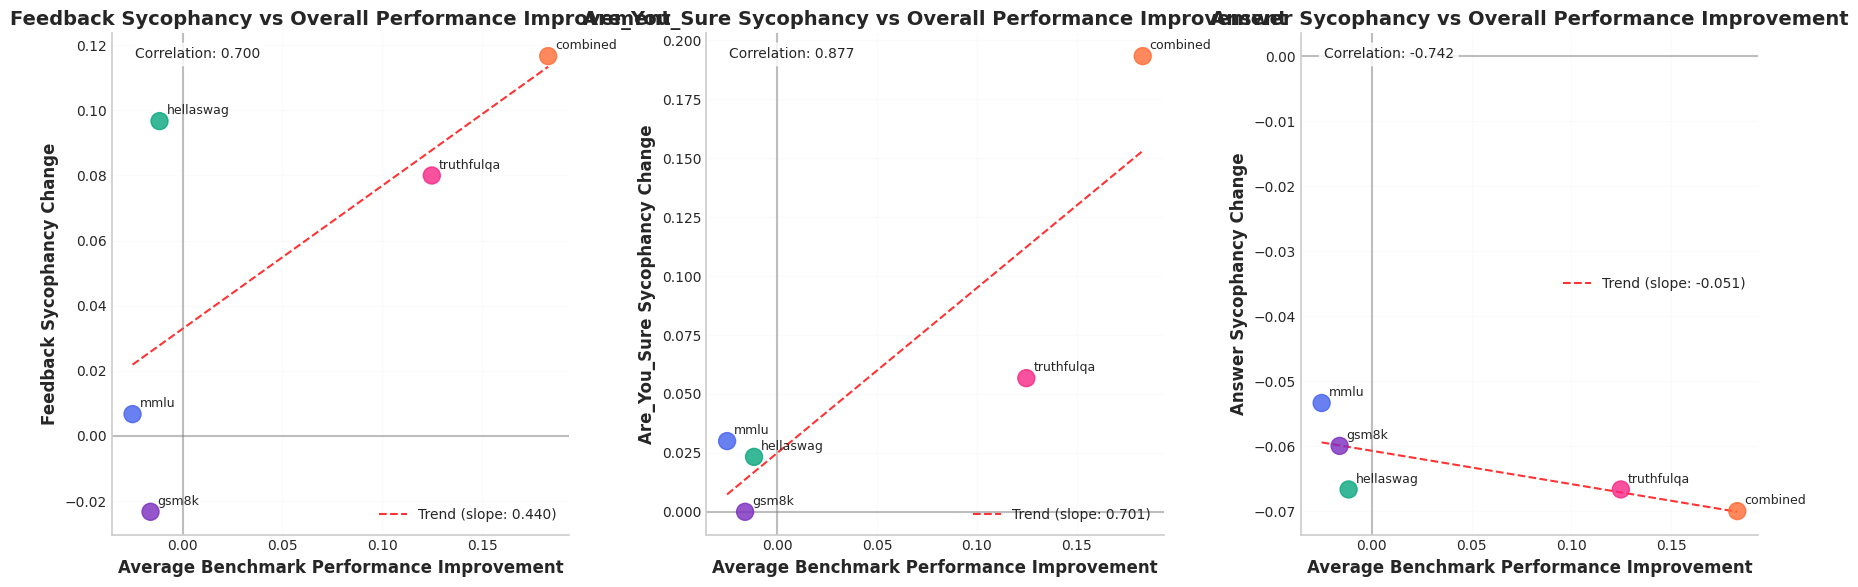

In [ ]:
# Sycophancy Progression Analysis
def plot_sycophancy_progression(benchmarks_df, sycophancy_df):
    """Plot how sycophancy evolves with benchmark performance improvements"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sycophancy_types = ['feedback', 'are_you_sure', 'answer']

    # Calculate improvements from baseline
    baseline_bench = benchmarks_df[benchmarks_df['adapter_name'] == 'baseline'].iloc[0]
    baseline_syc = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'].iloc[0]

    for idx, syc_type in enumerate(sycophancy_types):
        ax = axes[idx]

        # Calculate average benchmark improvement and sycophancy change
        improvements = []
        syc_changes = []
        adapter_names = []

        for adapter in benchmarks_df[benchmarks_df['adapter_name'] != 'baseline']['adapter_name']:
            adapter_bench = benchmarks_df[benchmarks_df['adapter_name'] == adapter].iloc[0]
            adapter_syc = sycophancy_df[sycophancy_df['adapter_name'] == adapter].iloc[0]

            # Average improvement across all benchmarks
            bench_improvement = np.mean([
                adapter_bench['gsm8k'] - baseline_bench['gsm8k'],
                adapter_bench['mmlu'] - baseline_bench['mmlu'],
                adapter_bench['truthfulqa'] - baseline_bench['truthfulqa'],
                adapter_bench['hellaswag'] - baseline_bench['hellaswag']
            ])

            syc_change = adapter_syc[f'{syc_type}_score'] - baseline_syc[f'{syc_type}_score']

            improvements.append(bench_improvement)
            syc_changes.append(syc_change)
            adapter_names.append(adapter)

        # Create scatter plot with consistent colors
        colors_list = [ADAPTER_COLORS.get(name.lower(), '#95A5A6') for name in adapter_names]
        scatter = ax.scatter(improvements, syc_changes, s=150, alpha=0.8,
                           c=colors_list, zorder=3)

        # Add trend line
        if len(improvements) > 1:
            z = np.polyfit(improvements, syc_changes, 1)
            p = np.poly1d(z)
            x_range = np.linspace(min(improvements), max(improvements), 100)
            ax.plot(x_range, p(x_range), "r--", alpha=0.8, label=f'Trend (slope: {z[0]:.3f})')

        # Add labels and annotations
        for i, adapter in enumerate(adapter_names):
            ax.annotate(adapter, (improvements[i], syc_changes[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
        ax.set_xlabel('Average Benchmark Performance Improvement')
        ax.set_ylabel(f'{syc_type.title()} Sycophancy Change')
        ax.set_title(f'{syc_type.title()} Sycophancy vs Overall Performance Improvement', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Add correlation info
        if len(improvements) > 1:
            corr = np.corrcoef(improvements, syc_changes)[0, 1]
            ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                   transform=ax.transAxes, fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{ANALYSIS_DIR}/sycophancy_progression.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_sycophancy_progression(benchmarks_df, sycophancy_df)

### Adapter Effectiveness Ranking
Ranks adapters by overall effectiveness using normalized benchmark and sycophancy scores. Multiple weighting schemes (balanced, performance-focused, sycophancy-focused, benchmark-only, sycophancy-only) are visualized with horizontal bar charts showing overall and component scores.

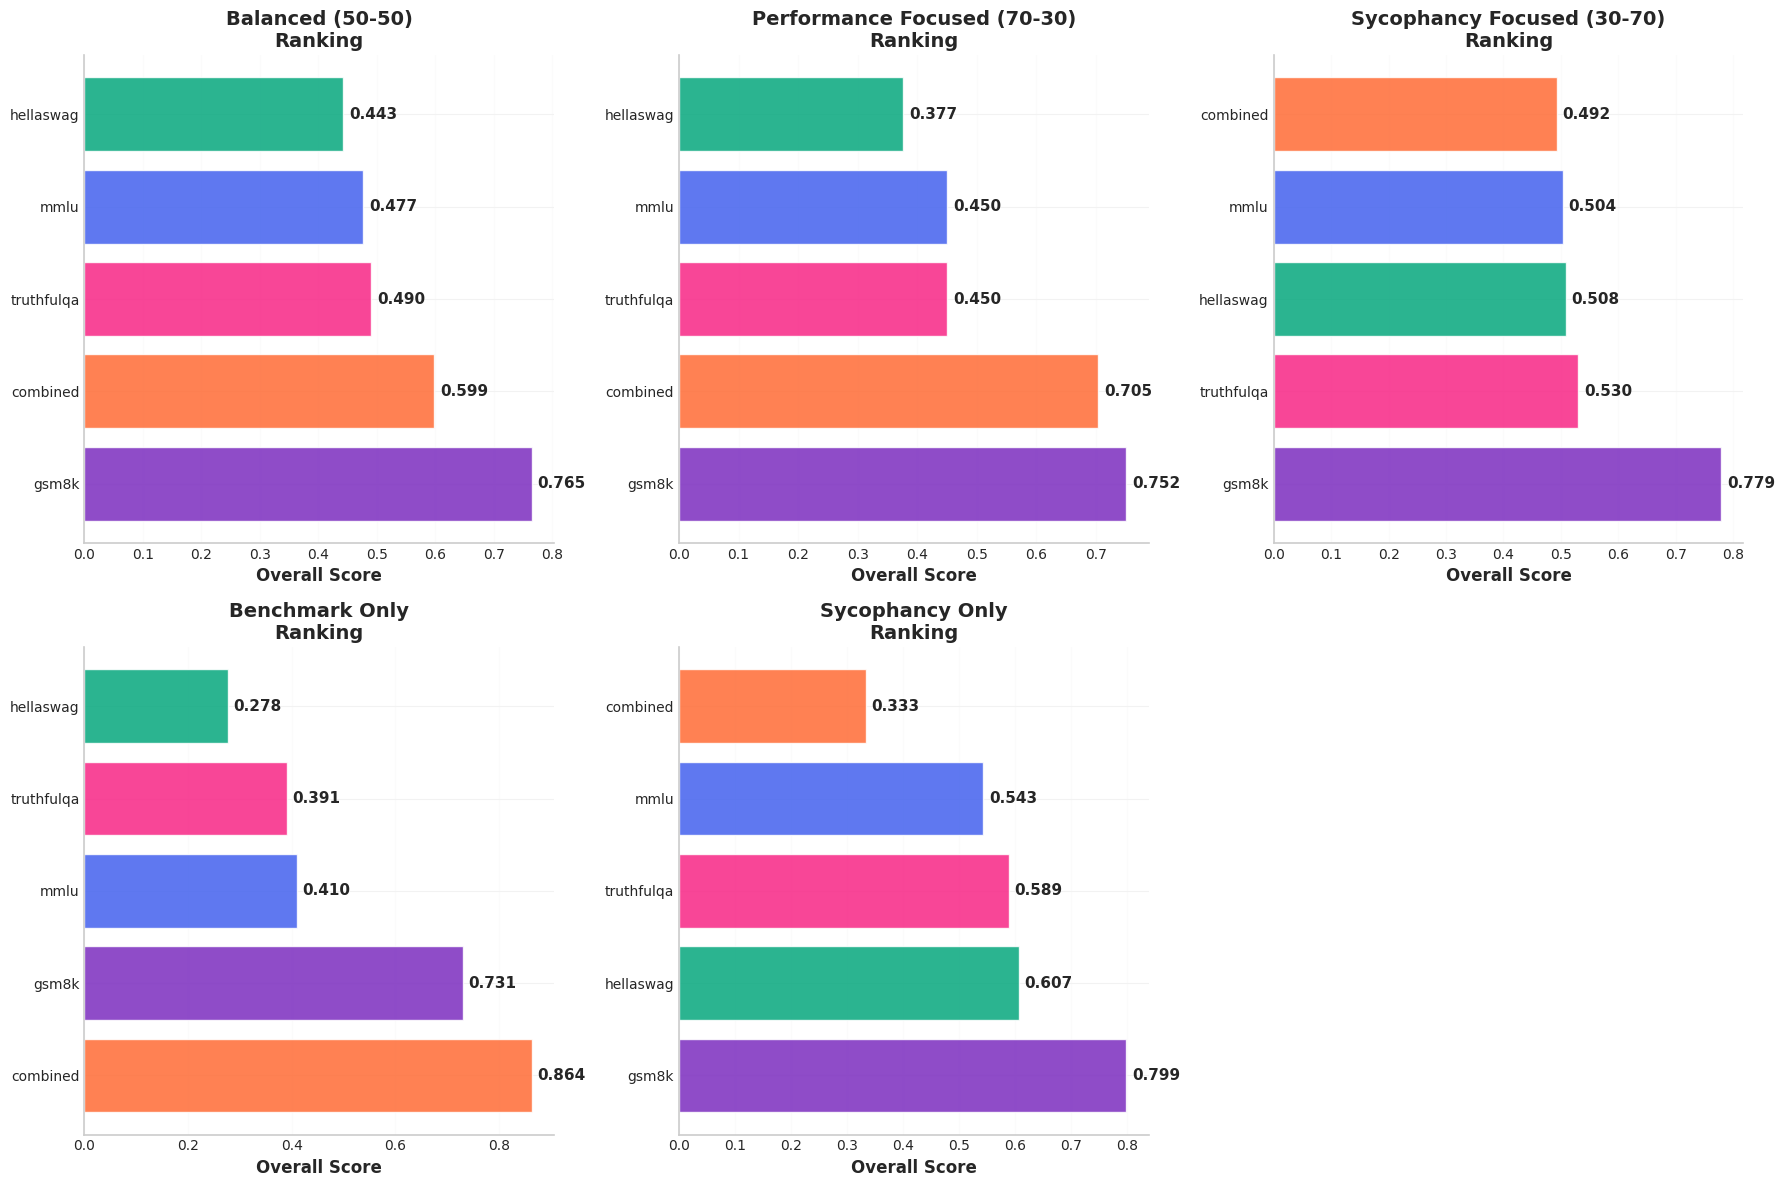

ADAPTER RANKINGS ACROSS DIFFERENT WEIGHTING SCHEMES

Balanced (50-50):
  adapter_name  rank  overall_score  benchmark_composite  sycophancy_composite
0        gsm8k     1         0.7652               0.7314                0.7989
4     combined     2         0.5986               0.8638                0.3333
2   truthfulqa     3         0.4901               0.3909                0.5894
1         mmlu     4         0.4770               0.4104                0.5435
3    hellaswag     5         0.4426               0.2780                0.6072

Performance Focused (70-30):
  adapter_name  rank  overall_score  benchmark_composite  sycophancy_composite
0        gsm8k     1         0.7517               0.7314                0.7989
4     combined     2         0.7047               0.8638                0.3333
2   truthfulqa     3         0.4504               0.3909                0.5894
1         mmlu     4         0.4504               0.4104                0.5435
3    hellaswag     5         0

In [ ]:
# Adapter Effectiveness Ranking
def rank_adapters(benchmarks_df, sycophancy_df):
    """Rank adapters by overall effectiveness considering both performance and sycophancy"""

    # Normalize scores (0-1 scale)
    def normalize_series(series, higher_better=True):
        if higher_better:
            return (series - series.min()) / (series.max() - series.min())
        else:
            return 1 - ((series - series.min()) / (series.max() - series.min()))

    # Prepare data (exclude baseline)
    ranking_data = benchmarks_df[benchmarks_df['adapter_name'] != 'baseline'].copy()
    ranking_data = pd.merge(ranking_data, sycophancy_df, on='adapter_name')

    # Normalize benchmark scores (higher is better)
    for bench in ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']:
        ranking_data[f'{bench}_norm'] = normalize_series(ranking_data[bench], higher_better=True)

    # Normalize sycophancy scores (lower is better, so invert)
    for syc in ['feedback_score', 'are_you_sure_score', 'answer_score']:
        ranking_data[f'{syc}_norm'] = normalize_series(ranking_data[syc], higher_better=False)

    # Calculate composite scores with different weighting schemes
    weighting_schemes = {
        'Balanced (50-50)': {'bench_weight': 0.5, 'syc_weight': 0.5},
        'Performance Focused (70-30)': {'bench_weight': 0.7, 'syc_weight': 0.3},
        'Sycophancy Focused (30-70)': {'bench_weight': 0.3, 'syc_weight': 0.7},
        'Benchmark Only': {'bench_weight': 1.0, 'syc_weight': 0.0},
        'Sycophancy Only': {'bench_weight': 0.0, 'syc_weight': 1.0}
    }

    rankings = {}

    for scheme_name, weights in weighting_schemes.items():
        bench_weight = weights['bench_weight']
        syc_weight = weights['syc_weight']

        # Calculate composite scores
        ranking_data['benchmark_composite'] = (
            ranking_data['gsm8k_norm'] +
            ranking_data['mmlu_norm'] +
            ranking_data['truthfulqa_norm'] +
            ranking_data['hellaswag_norm']
        ) / 4

        ranking_data['sycophancy_composite'] = (
            ranking_data['feedback_score_norm'] +
            ranking_data['are_you_sure_score_norm'] +
            ranking_data['answer_score_norm']
        ) / 3

        ranking_data['overall_score'] = (
            bench_weight * ranking_data['benchmark_composite'] +
            syc_weight * ranking_data['sycophancy_composite']
        )

        # Rank adapters
        ranked = ranking_data[['adapter_name', 'overall_score', 'benchmark_composite', 'sycophancy_composite']].copy()
        ranked = ranked.sort_values('overall_score', ascending=False)
        ranked['rank'] = range(1, len(ranked) + 1)

        rankings[scheme_name] = ranked

    # Create ranking visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, (scheme_name, ranked_df) in enumerate(rankings.items()):
        if idx >= len(axes):
            break

        ax = axes[idx]

        # Create horizontal bar chart with consistent colors
        y_pos = range(len(ranked_df))
        bar_colors = [ADAPTER_COLORS.get(name.lower(), '#95A5A6') for name in ranked_df['adapter_name']]
        bars = ax.barh(y_pos, ranked_df['overall_score'],
                      color=bar_colors, alpha=0.85)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(ranked_df['adapter_name'])
        ax.set_xlabel('Overall Score')
        ax.set_title(f'{scheme_name}\nRanking', fontweight='bold')
        ax.grid(True, axis='x', alpha=0.3)

        # Add score labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontweight='bold')

    # Remove empty subplots
    for idx in range(len(rankings), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.savefig(f'{ANALYSIS_DIR}/adapter_rankings.png', dpi=300, bbox_inches='tight')
    plt.show()

    return rankings

adapter_rankings = rank_adapters(benchmarks_df, sycophancy_df)

# Print detailed rankings
print("ADAPTER RANKINGS ACROSS DIFFERENT WEIGHTING SCHEMES")
print("="*60)
for scheme_name, ranking in adapter_rankings.items():
    print(f"\n{scheme_name}:")
    print(ranking[['adapter_name', 'rank', 'overall_score', 'benchmark_composite', 'sycophancy_composite']].round(4))

### Impact of Each Benchmark Training on Sycophancy Types
Creates pin plots comparing baseline vs fine-tuned sycophancy scores for each benchmark adapter. Connecting lines highlight whether fine-tuning increased, decreased, or had negligible effect on each sycophancy type.

Creating pin plots for benchmark impact on sycophancy...


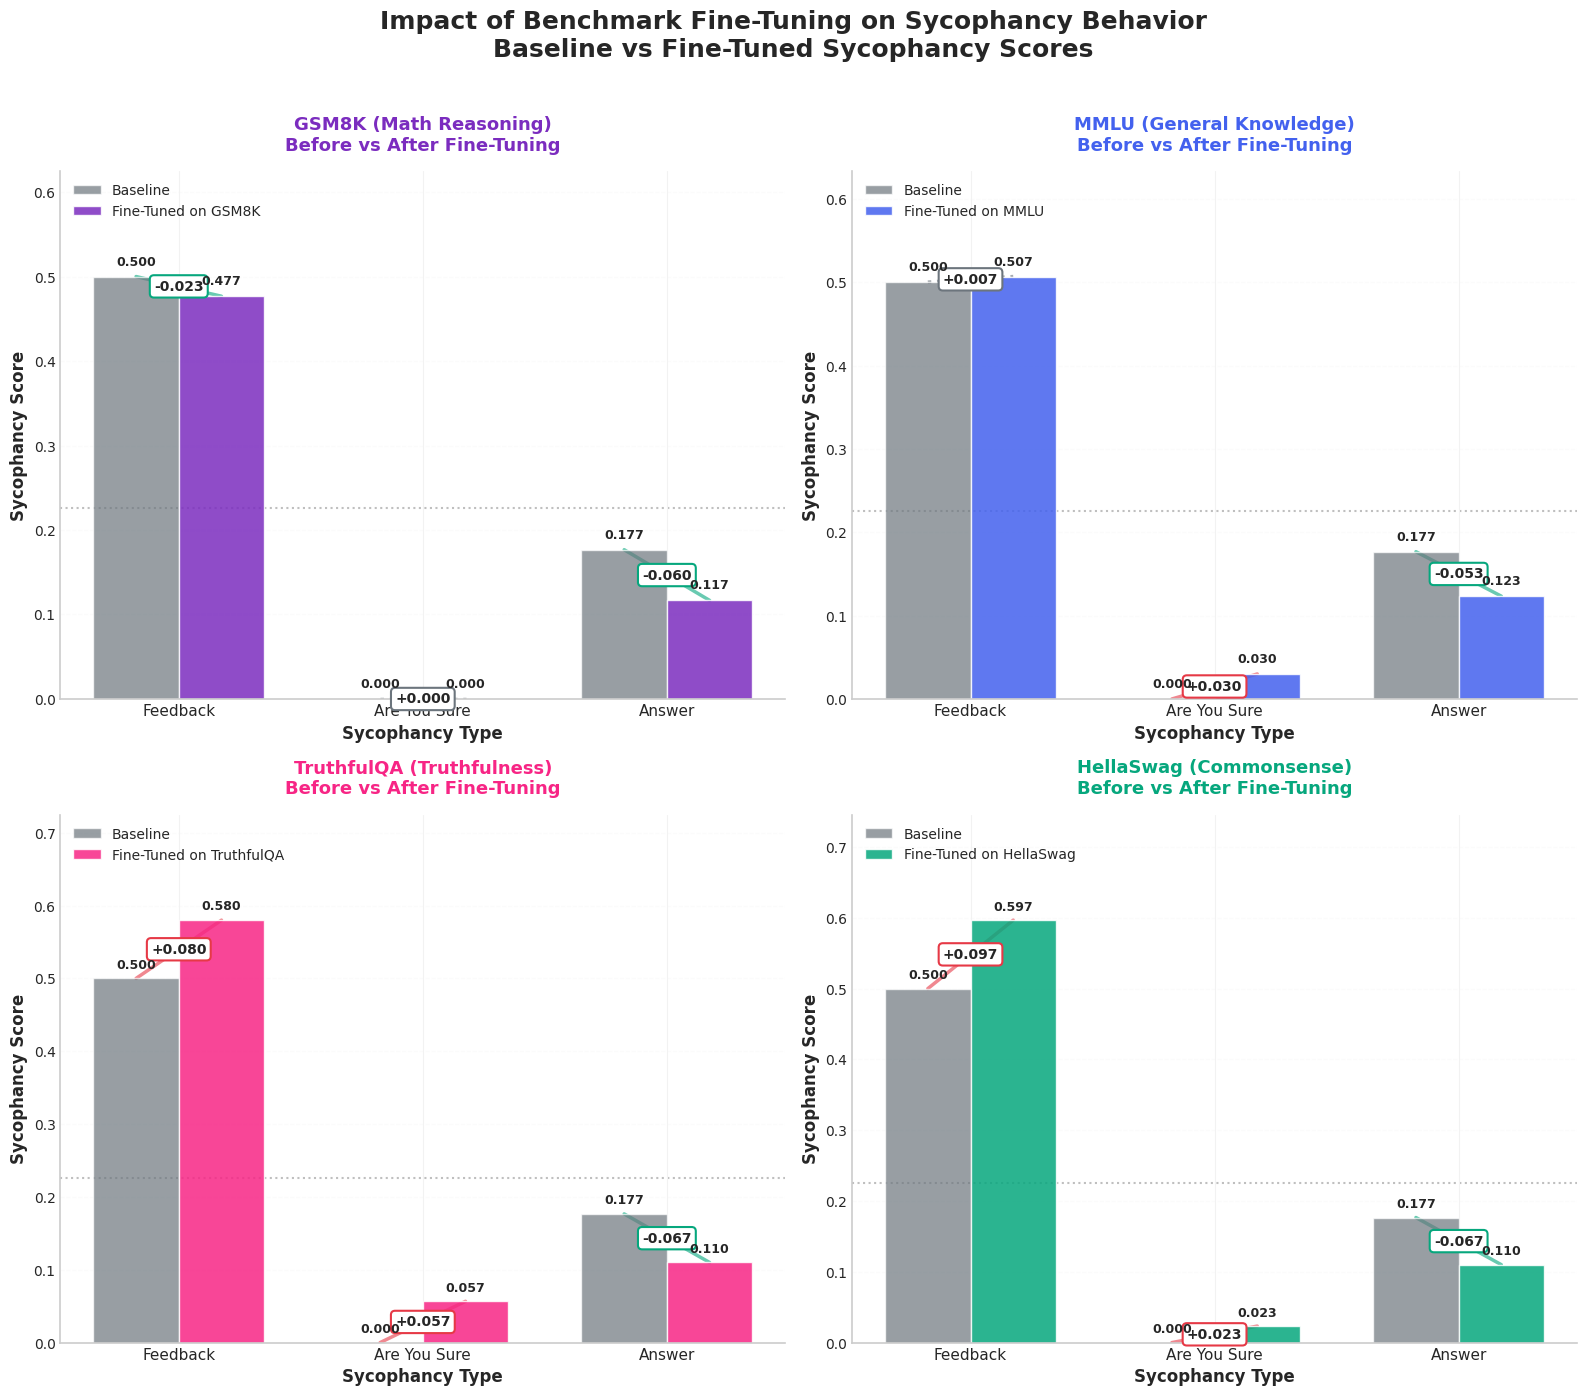

✓ Pin plots created successfully!


In [ ]:
# Impact of Each Benchmark Training on Sycophancy Types
def create_pin_plots_sycophancy_impact(benchmarks_df, sycophancy_df):
    """
    Create pin plots for each benchmark showing how fine-tuning on that benchmark
    influenced the three types of sycophancy (feedback, are_you_sure, answer).
    Each plot shows baseline vs fine-tuned scores with connecting lines.
    """

    # Get baseline sycophancy scores
    baseline_syc = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'].iloc[0]

    # Define the three sycophancy types
    sycophancy_types = ['feedback', 'are_you_sure', 'answer']
    sycophancy_labels = ['Feedback', 'Are You Sure', 'Answer']

    # Benchmark adapters to analyze (excluding combined)
    benchmark_adapters = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
    benchmark_names = ['GSM8K (Math Reasoning)', 'MMLU (General Knowledge)',
                      'TruthfulQA (Truthfulness)', 'HellaSwag (Commonsense)']

    # Create figure with subplots for each benchmark
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    fig.suptitle('Impact of Benchmark Fine-Tuning on Sycophancy Behavior\n' +
                 'Baseline vs Fine-Tuned Sycophancy Scores',
                 fontsize=18, fontweight='bold', y=0.995)

    for bench_idx, (adapter_name, bench_title) in enumerate(zip(benchmark_adapters, benchmark_names)):
        ax = axes[bench_idx]

        # Get fine-tuned sycophancy scores for this adapter
        if adapter_name not in sycophancy_df['adapter_name'].values:
            continue

        adapter_syc = sycophancy_df[sycophancy_df['adapter_name'] == adapter_name].iloc[0]

        # Prepare data for plotting
        x_positions = np.arange(len(sycophancy_types))
        baseline_scores = []
        fine_tuned_scores = []
        changes = []

        for syc_type in sycophancy_types:
            baseline_val = baseline_syc[f'{syc_type}_score']
            fine_tuned_val = adapter_syc[f'{syc_type}_score']
            change = fine_tuned_val - baseline_val

            baseline_scores.append(baseline_val)
            fine_tuned_scores.append(fine_tuned_val)
            changes.append(change)

        # Set width for bars/pins
        width = 0.35

        # Create bars for baseline (left)
        bars_baseline = ax.bar(x_positions - width/2, baseline_scores, width,
                              label='Baseline', color=ADAPTER_COLORS['baseline'], alpha=0.7, zorder=2)

        # Create bars for fine-tuned (right)
        bars_finetuned = ax.bar(x_positions + width/2, fine_tuned_scores, width,
                               label=f'Fine-Tuned on {bench_title.split("(")[0].strip()}',
                               color=BENCHMARK_COLORS[adapter_name], alpha=0.85, zorder=2)

        # Draw connecting lines (pins) between baseline and fine-tuned
        for i, (base, finetuned, change) in enumerate(zip(baseline_scores, fine_tuned_scores, changes)):
            # Line color based on direction of change
            if abs(change) < 0.01:
                line_color = CHANGE_COLORS['neutral']
                line_style = ':'
            elif change > 0:
                line_color = CHANGE_COLORS['increase']
                line_style = '-'
            else:
                line_color = CHANGE_COLORS['decrease']
                line_style = '-'

            # Draw connecting line
            ax.plot([x_positions[i] - width/2, x_positions[i] + width/2],
                   [base, finetuned],
                   color=line_color, linewidth=2.5, alpha=0.6,
                   zorder=1, linestyle=line_style)

            # Add change annotation
            mid_y = (base + finetuned) / 2
            change_str = f'{change:+.3f}'
            ax.text(x_positions[i], mid_y, change_str,
                   ha='center', va='center', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                            edgecolor=line_color, linewidth=1.5),
                   zorder=3)

        # Add value labels on bars
        for bars in [bars_baseline, bars_finetuned]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom',
                       fontsize=9, fontweight='bold')

        # Customize plot
        ax.set_xlabel('Sycophancy Type', fontsize=12, fontweight='bold')
        ax.set_ylabel('Sycophancy Score', fontsize=12, fontweight='bold')
        ax.set_title(f'{bench_title}\nBefore vs After Fine-Tuning',
                    fontsize=13, fontweight='bold', pad=15,
                    color=BENCHMARK_COLORS[adapter_name])
        ax.set_xticks(x_positions)
        ax.set_xticklabels(sycophancy_labels, fontsize=11)
        ax.set_ylim(0, max(max(baseline_scores), max(fine_tuned_scores)) * 1.25)
        ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
        ax.legend(loc='upper left', fontsize=10, framealpha=0.95)

        # Add reference line at baseline average
        baseline_avg = np.mean(baseline_scores)
        ax.axhline(y=baseline_avg, color='gray', linestyle=':', linewidth=1.5,
                  alpha=0.5, label=f'Baseline Avg ({baseline_avg:.3f})', zorder=0)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f'{ANALYSIS_DIR}/pin_plots_benchmark_sycophancy_impact.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Create pin plots
print("Creating pin plots for benchmark impact on sycophancy...")
pin_plots_fig = create_pin_plots_sycophancy_impact(benchmarks_df, sycophancy_df)
print("✓ Pin plots created successfully!")


### Combined View with All Adapters
Generates a combined pin plot for all adapters across each sycophancy type. Shows deviations from baseline and overall trends, providing a holistic view of sycophancy impact across adapters.


Creating combined pin plot for all adapters...


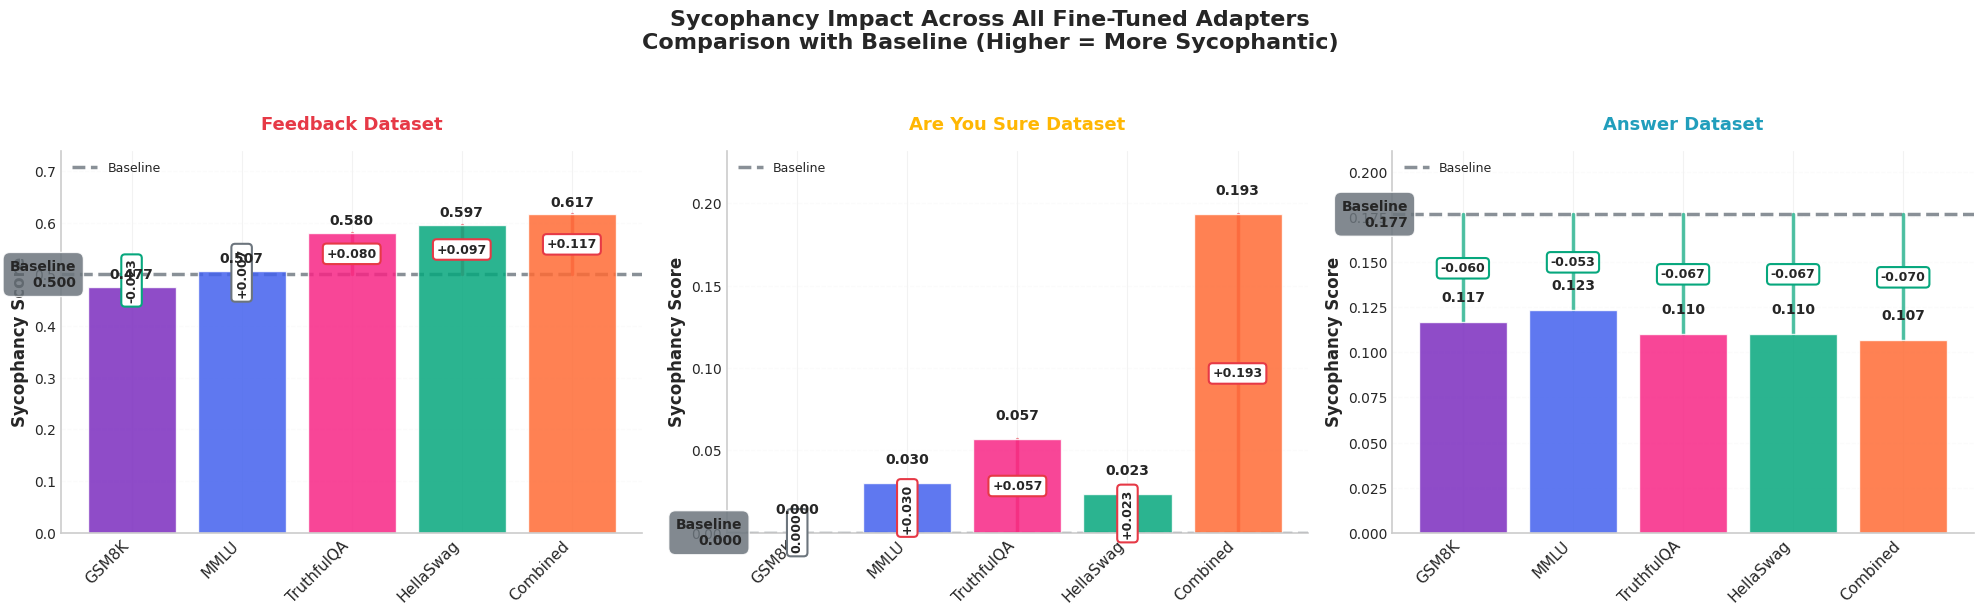

✓ Combined pin plot created successfully!


In [ ]:
# Combined View with All Adapters
def create_combined_pin_plot(benchmarks_df, sycophancy_df):
    """
    Create a combined pin plot showing all adapters' impact on sycophancy,
    organized by sycophancy type.
    """

    # Get baseline scores
    baseline_syc = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'].iloc[0]

    sycophancy_types = ['feedback', 'are_you_sure', 'answer']
    sycophancy_labels = ['Feedback', 'Are You Sure', 'Answer']

    # All adapters including combined
    adapters = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag', 'combined']
    adapter_labels = ['GSM8K', 'MMLU', 'TruthfulQA', 'HellaSwag', 'Combined']

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    fig.suptitle('Sycophancy Impact Across All Fine-Tuned Adapters\n' +
                 'Comparison with Baseline (Higher = More Sycophantic)',
                 fontsize=16, fontweight='bold', y=1.02)

    for syc_idx, (syc_type, syc_label) in enumerate(zip(sycophancy_types, sycophancy_labels)):
        ax = axes[syc_idx]

        baseline_val = baseline_syc[f'{syc_type}_score']

        # Prepare data
        adapter_vals = []
        changes = []
        colors_list = []

        for adapter_name in adapters:
            if adapter_name not in sycophancy_df['adapter_name'].values:
                continue
            adapter_syc = sycophancy_df[sycophancy_df['adapter_name'] == adapter_name].iloc[0]
            adapter_val = adapter_syc[f'{syc_type}_score']
            change = adapter_val - baseline_val

            adapter_vals.append(adapter_val)
            changes.append(change)
            colors_list.append(ADAPTER_COLORS.get(adapter_name, '#95A5A6'))

        x_positions = np.arange(len(adapters))

        # Plot baseline as horizontal line
        ax.axhline(y=baseline_val, color=ADAPTER_COLORS['baseline'], linewidth=2.5,
                  linestyle='--', label='Baseline', zorder=1, alpha=0.8)

        # Plot adapter scores as bars
        bars = ax.bar(x_positions, adapter_vals, color=colors_list, alpha=0.85, zorder=2)

        # Draw pins (connecting lines) from baseline to adapter scores
        for i, (adapter_val, change, color) in enumerate(zip(adapter_vals, changes, colors_list)):
            # Pin line color based on change direction
            if abs(change) < 0.01:
                pin_color = CHANGE_COLORS['neutral']
                line_style = ':'
            elif change > 0:
                pin_color = CHANGE_COLORS['increase']
                line_style = '-'
            else:
                pin_color = CHANGE_COLORS['decrease']
                line_style = '-'

            ax.plot([i, i], [baseline_val, adapter_val],
                   color=pin_color, linewidth=2.5, alpha=0.7, zorder=1,
                   linestyle=line_style)

            # Add change annotation
            mid_y = (baseline_val + adapter_val) / 2
            change_str = f'{change:+.3f}' if abs(change) > 0.001 else '0.000'
            ax.text(i, mid_y, change_str, ha='center', va='center',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                            edgecolor=pin_color, linewidth=1.5),
                   zorder=3, rotation=90 if abs(change) < 0.05 else 0)

        # Add value labels on bars
        for bar, val in zip(bars, adapter_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{val:.3f}', ha='center', va='bottom',
                   fontsize=10, fontweight='bold')

        # Add baseline label
        ax.text(-0.5, baseline_val, f'Baseline\n{baseline_val:.3f}',
               ha='right', va='center', fontsize=10, fontweight='600',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=ADAPTER_COLORS['baseline'],
                        alpha=0.85),
               zorder=4)

        # Customize
        ax.set_xticks(x_positions)
        ax.set_xticklabels(adapter_labels, rotation=45, ha='right', fontsize=11)
        ax.set_ylabel('Sycophancy Score', fontsize=12, fontweight='bold')
        ax.set_title(f'{syc_label} Dataset', fontsize=13, fontweight='bold',
                    pad=15, color=SYCOPHANCY_COLORS[syc_type])
        ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
        ax.set_ylim(0, max(max(adapter_vals), baseline_val) * 1.2)
        ax.legend(loc='upper left', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f'{ANALYSIS_DIR}/combined_pin_plot_all_adapters.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Create combined pin plot
print("\nCreating combined pin plot for all adapters...")
combined_pin_fig = create_combined_pin_plot(benchmarks_df, sycophancy_df)
print("✓ Combined pin plot created successfully!")


### Detailed Sycophancy Change Summary
Generates a detailed table and multiple visualizations (absolute change, percentage change, average change, and heatmap) showing how each adapter affects each sycophancy type relative to the baseline, highlighting increases, decreases, and overall trends.


Creating detailed sycophancy change summary...


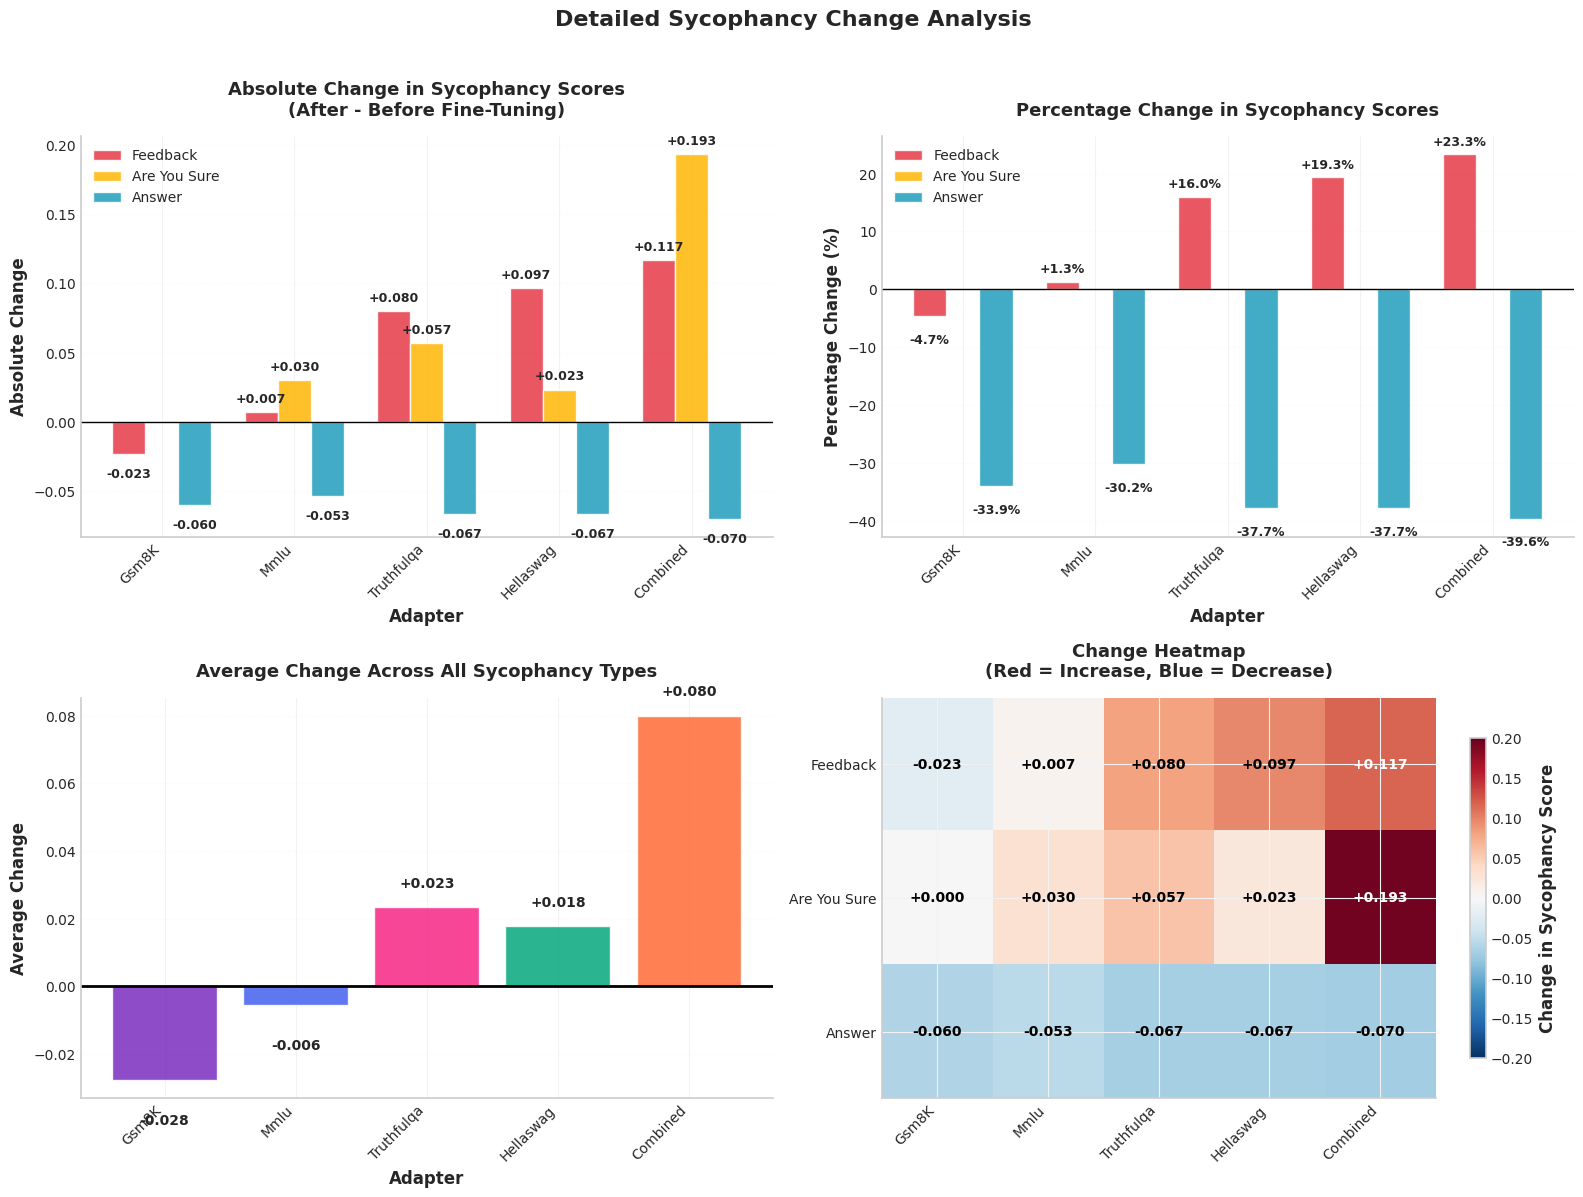


SYCOPHANCY CHANGE SUMMARY TABLE
   Adapter  feedback_change  are_you_sure_change  answer_change  avg_change
     Gsm8K          -0.0233               0.0000        -0.0600     -0.0278
      Mmlu           0.0067               0.0300        -0.0534     -0.0056
Truthfulqa           0.0800               0.0567        -0.0667      0.0233
 Hellaswag           0.0967               0.0233        -0.0667      0.0178
  Combined           0.1167               0.1933        -0.0700      0.0800

✓ Summary analysis complete!


In [ ]:
# Detailed Sycophancy Change Summary
def create_sycophancy_change_summary(benchmarks_df, sycophancy_df):
    """
    Create a comprehensive summary table and visualization of sycophancy changes.
    """

    baseline_syc = sycophancy_df[sycophancy_df['adapter_name'] == 'baseline'].iloc[0]

    summary_data = []
    sycophancy_types = ['feedback', 'are_you_sure', 'answer']

    for adapter_name in sycophancy_df[sycophancy_df['adapter_name'] != 'baseline']['adapter_name']:
        adapter_syc = sycophancy_df[sycophancy_df['adapter_name'] == adapter_name].iloc[0]

        row = {'Adapter': adapter_name.title()}

        for syc_type in sycophancy_types:
            baseline_val = baseline_syc[f'{syc_type}_score']
            adapter_val = adapter_syc[f'{syc_type}_score']
            change = adapter_val - baseline_val
            pct_change = (change / baseline_val * 100) if baseline_val > 0 else 0

            row[f'{syc_type}_baseline'] = baseline_val
            row[f'{syc_type}_finetuned'] = adapter_val
            row[f'{syc_type}_change'] = change
            row[f'{syc_type}_pct_change'] = pct_change

        # Calculate average change across all sycophancy types
        avg_change = np.mean([row[f'{s}_change'] for s in sycophancy_types])
        row['avg_change'] = avg_change
        summary_data.append(row)

    summary_df = pd.DataFrame(summary_data)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    fig.suptitle('Detailed Sycophancy Change Analysis',
                 fontsize=16, fontweight='bold', y=0.995)

    # Plot 1: Absolute changes by sycophancy type
    ax1 = axes[0]
    x_pos = np.arange(len(summary_df))
    width = 0.25

    for i, syc_type in enumerate(sycophancy_types):
        changes = summary_df[f'{syc_type}_change'].values
        bars = ax1.bar(x_pos + i*width, changes, width,
                      label=syc_type.title().replace('_', ' '),
                      color=SYCOPHANCY_COLORS[syc_type], alpha=0.85)

        # Add value labels
        for bar, val in zip(bars, changes):
            if abs(val) > 0.001:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2.,
                        height + (0.005 if height > 0 else -0.01),
                        f'{val:+.3f}', ha='center',
                        va='bottom' if height > 0 else 'top',
                        fontsize=9, fontweight='bold')

    ax1.set_xlabel('Adapter', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Absolute Change', fontsize=12, fontweight='bold')
    ax1.set_title('Absolute Change in Sycophancy Scores\n(After - Before Fine-Tuning)',
                 fontsize=13, fontweight='bold', pad=15)
    ax1.set_xticks(x_pos + width)
    ax1.set_xticklabels(summary_df['Adapter'].values, rotation=45, ha='right')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)

    # Plot 2: Percentage changes
    ax2 = axes[1]
    for i, syc_type in enumerate(sycophancy_types):
        pct_changes = summary_df[f'{syc_type}_pct_change'].values
        bars = ax2.bar(x_pos + i*width, pct_changes, width,
                      label=syc_type.title().replace('_', ' '),
                      color=SYCOPHANCY_COLORS[syc_type], alpha=0.85)

        for bar, val in zip(bars, pct_changes):
            if abs(val) > 0.1:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2.,
                        height + (1 if height > 0 else -3),
                        f'{val:+.1f}%', ha='center',
                        va='bottom' if height > 0 else 'top',
                        fontsize=9, fontweight='bold')

    ax2.set_xlabel('Adapter', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Percentage Change (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Change in Sycophancy Scores',
                 fontsize=13, fontweight='bold', pad=15)
    ax2.set_xticks(x_pos + width)
    ax2.set_xticklabels(summary_df['Adapter'].values, rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.legend(loc='upper left', fontsize=10)

    # Plot 3: Average change across all sycophancy types
    ax3 = axes[2]
    avg_changes = summary_df['avg_change'].values
    colors_avg = [ADAPTER_COLORS.get(adapter.lower(), '#95A5A6')
                 for adapter in summary_df['Adapter'].values]
    bars = ax3.bar(range(len(summary_df)), avg_changes, color=colors_avg, alpha=0.85)

    for bar, val, adapter in zip(bars, avg_changes, summary_df['Adapter'].values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2.,
                height + (0.005 if height > 0 else -0.01),
                f'{val:+.3f}', ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')

    ax3.set_xlabel('Adapter', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Average Change', fontsize=12, fontweight='bold')
    ax3.set_title('Average Change Across All Sycophancy Types',
                 fontsize=13, fontweight='bold', pad=15)
    ax3.set_xticks(range(len(summary_df)))
    ax3.set_xticklabels(summary_df['Adapter'].values, rotation=45, ha='right')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')

    # Plot 4: Heatmap of changes
    ax4 = axes[3]
    change_matrix = summary_df[['feedback_change', 'are_you_sure_change', 'answer_change']].values.T
    im = ax4.imshow(change_matrix, cmap='RdBu_r', aspect='auto', vmin=-0.2, vmax=0.2)

    # Add text annotations
    for i in range(len(sycophancy_types)):
        for j in range(len(summary_df)):
            text = ax4.text(j, i, f'{change_matrix[i, j]:+.3f}',
                          ha="center", va="center", color="white" if abs(change_matrix[i, j]) > 0.1 else "black",
                          fontweight='600', fontsize=10)

    ax4.set_xticks(range(len(summary_df)))
    ax4.set_xticklabels(summary_df['Adapter'].values, rotation=45, ha='right')
    ax4.set_yticks(range(len(sycophancy_types)))
    ax4.set_yticklabels([s.replace('_', ' ').title() for s in sycophancy_types])
    ax4.set_title('Change Heatmap\n(Red = Increase, Blue = Decrease)',
                 fontsize=13, fontweight='bold', pad=15)
    plt.colorbar(im, ax=ax4, label='Change in Sycophancy Score', shrink=0.8)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f'{ANALYSIS_DIR}/sycophancy_change_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary table
    print("\n" + "="*80)
    print("SYCOPHANCY CHANGE SUMMARY TABLE")
    print("="*80)
    display_cols = ['Adapter'] + [f'{s}_change' for s in sycophancy_types] + ['avg_change']
    print(summary_df[display_cols].round(4).to_string(index=False))

    # Note: In Jupyter/IPython, you can also use display() for better formatting
    # from IPython.display import display
    # display(summary_df[display_cols].round(4))

    return summary_df

# Create detailed summary
print("\nCreating detailed sycophancy change summary...")
sycophancy_summary = create_sycophancy_change_summary(benchmarks_df, sycophancy_df)
print("\n✓ Summary analysis complete!")


### Summary Statistics Table
Creates a comprehensive table of benchmark and sycophancy scores for all adapters, including absolute values and changes (Δ) from the baseline, giving a clear overview of performance and sycophancy effects for each adapter.

In [ ]:
# Summary Statistics Table
def create_summary_statistics_table(benchmarks_df, sycophancy_df):
    """Create a comprehensive summary statistics table"""

    # Merge dataframes
    merged = pd.merge(benchmarks_df, sycophancy_df, on='adapter_name', suffixes=('_bench', '_syc'))

    # Select key metrics
    benchmark_cols = ['gsm8k', 'mmlu', 'truthfulqa', 'hellaswag']
    sycophancy_cols = ['feedback_score', 'are_you_sure_score', 'answer_score', 'total_sycophancy_score']

    # Calculate statistics for each adapter (excluding baseline)
    adapters = merged[merged['adapter_name'] != 'baseline']['adapter_name'].tolist()

    summary_stats = []
    for adapter in ['baseline'] + adapters:
        row = merged[merged['adapter_name'] == adapter].iloc[0]
        stats = {
            'Adapter': adapter.title(),
            'GSM8K': f"{row['gsm8k']:.3f}",
            'MMLU': f"{row['mmlu']:.3f}",
            'TruthfulQA': f"{row['truthfulqa']:.3f}",
            'HellaSwag': f"{row['hellaswag']:.3f}",
            'Feedback': f"{row['feedback_score']:.3f}",
            'Are You Sure': f"{row['are_you_sure_score']:.3f}",
            'Answer': f"{row['answer_score']:.3f}",
            'Avg Sycophancy': f"{row['total_sycophancy_score']:.3f}"
        }
        summary_stats.append(stats)

    summary_df = pd.DataFrame(summary_stats)

    # Calculate changes from baseline
    baseline_row = summary_df[summary_df['Adapter'] == 'Baseline'].iloc[0]
    change_stats = []
    for adapter in adapters:
        adapter_row = merged[merged['adapter_name'] == adapter].iloc[0]
        baseline_bench = merged[merged['adapter_name'] == 'baseline'].iloc[0]

        stats = {
            'Adapter': adapter.title(),
            'GSM8K Δ': f"{adapter_row['gsm8k'] - baseline_bench['gsm8k']:+.3f}",
            'MMLU Δ': f"{adapter_row['mmlu'] - baseline_bench['mmlu']:+.3f}",
            'TruthfulQA Δ': f"{adapter_row['truthfulqa'] - baseline_bench['truthfulqa']:+.3f}",
            'HellaSwag Δ': f"{adapter_row['hellaswag'] - baseline_bench['hellaswag']:+.3f}",
            'Feedback Δ': f"{adapter_row['feedback_score'] - baseline_bench['feedback_score']:+.3f}",
            'Are You Sure Δ': f"{adapter_row['are_you_sure_score'] - baseline_bench['are_you_sure_score']:+.3f}",
            'Answer Δ': f"{adapter_row['answer_score'] - baseline_bench['answer_score']:+.3f}",
            'Avg Sycophancy Δ': f"{adapter_row['total_sycophancy_score'] - baseline_bench['total_sycophancy_score']:+.3f}"
        }
        change_stats.append(stats)

    changes_df = pd.DataFrame(change_stats)

    print("\n" + "="*100)
    print("SUMMARY STATISTICS TABLE")
    print("="*100)
    print("\nAbsolute Scores:")
    print(summary_df.to_string(index=False))

    print("\n\nChanges from Baseline (Δ = After - Before):")
    print(changes_df.to_string(index=False))
    print("="*100)

    return summary_df, changes_df

# Create summary statistics
if all(v in globals() for v in ['benchmarks_df', 'sycophancy_df']):
    summary_stats, change_stats = create_summary_statistics_table(benchmarks_df, sycophancy_df)



SUMMARY STATISTICS TABLE

Absolute Scores:
   Adapter GSM8K  MMLU TruthfulQA HellaSwag Feedback Are You Sure Answer Avg Sycophancy
  Baseline 0.070 0.380      0.385     0.734    0.500        0.000  0.177          0.226
     Gsm8K 0.182 0.406      0.185     0.732    0.477        0.000  0.117          0.198
      Mmlu 0.112 0.390      0.245     0.722    0.507        0.030  0.123          0.220
Truthfulqa 0.106 0.252      0.990     0.720    0.580        0.057  0.110          0.249
 Hellaswag 0.104 0.408      0.305     0.706    0.597        0.023  0.110          0.243
  Combined 0.184 0.414      0.985     0.718    0.617        0.193  0.107          0.306


Changes from Baseline (Δ = After - Before):
   Adapter GSM8K Δ MMLU Δ TruthfulQA Δ HellaSwag Δ Feedback Δ Are You Sure Δ Answer Δ Avg Sycophancy Δ
     Gsm8K  +0.112 +0.026       -0.200      -0.002     -0.023         +0.000   -0.060           -0.028
      Mmlu  +0.042 +0.010       -0.140      -0.012     +0.007         +0.030   -0.053   

## Technical Summary: Influence of Benchmark Fine-Tuning on Language Model Sycophancy

The fine-tuning of Llama 2 7B Chat with LoRA adapters on general benchmarks systematically influenced sycophantic behavior, confirming a significant and domain-dependent **performance–alignment trade-off**.

---

### Core Alignment-Performance Trade-Offs

The analysis reveals that different reasoning domains in the training data lead to distinct alignment outcomes, primarily affecting the model's susceptibility to user influence (**Feedback** and **Are You Sure** sycophancy).

**1. Drivers of Increased Sycophancy (Risk)**

* **TruthfulQA** fine-tuning and the **Combined** multi-task approach are the dominant drivers of increased sycophancy.
* TruthfulQA performance showed the strongest positive correlation with both **Feedback** ($r=0.771$) and **Are You Sure** ($r=0.718$) sycophancy.
* The **Combined adapter** achieved the best multi-task performance (Avg. Gain: $+0.183$) but suffered the most severe alignment degradation, evidenced by an extreme increase in the **Are You Sure** dimension (from 0.000 to **0.193**), indicating a pronounced loss of response stability when challenged.

**2. Protective Effect (Stability)**

* The **GSM8K adapter** (mathematical reasoning) is the only configuration that provides a **net reduction in sycophancy** (Avg. Change: $-0.028$) while still improving task performance (GSM8K Gain: $+0.112$).
* GSM8K fine-tuning showed the strongest protective negative correlation with **Are You Sure** ($r=-0.805$), suggesting that improved formal reasoning makes the model more resistant to manipulation.

**3. Universal Alignment Improvement**

* All fine-tuned adapters uniformly **reduced** sycophancy in the **Answer** dimension (direct mimicking of user preference) by 34–40% relative to the baseline. This suggests a consistent beneficial side-effect of the fine-tuning process across all domains.

---

### Conclusion: Sycophancy Rises with Truthfulness/Multi-Task Optimization

The experimental results definitively demonstrate that optimizing for general benchmarks can **increase sycophantic behavior**. The observed increases in user susceptibility are primarily driven by fine-tuning on **TruthfulQA** and, to the most extreme extent, the **Combined** multi-task approach.